In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil

In [2]:
def load_cfar10_batch(path):
    """ Based on: https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c
    """
    with open(path, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = np.array(batch['labels'])
        
    return features, labels

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# train set is batch 1, val set is batch 2, test set is test

path = os.path.join("data", "data_batch_1")
x_train_img, y_train = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_val_img, y_val = load_cfar10_batch(path)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

In [4]:
# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

#np.testing.assert_array_equal(train_ratios, val_ratios)
#np.testing.assert_array_equal(val_ratios, test_ratios)

np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

train set shape: (10000, 32, 32, 3), val set shape: (10000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (10000,), val labels shape: (10000,), test labels shape: (10000,)


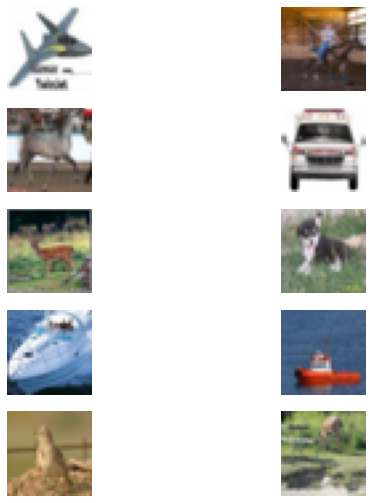

In [5]:
# show some random pics

show_n = 10
assert show_n % 2 == 0, f"{show_n} needs to be an even number"
np.random.seed(100)
show_indices = np.random.choice(x_train_img.shape[0], show_n, replace=False)
x_train_img_show = x_train_img[show_indices]

fig, axs = plt.subplots(show_n // 2, 2,figsize=(9,9))

for idx, img in enumerate(x_train_img_show):
    col_idx = 1 - int(idx % 2 == 0)
    ax = axs[idx // 2, col_idx]
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [6]:
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

In [7]:
print(np.mean(x_train, axis=0))
print(np.mean(x_train, axis=0).shape)
print(np.std(x_train, axis=0))
print(x_train.shape)

print(np.mean(x_val, axis=0))
print(np.std(x_val, axis=0))

print(np.mean(x_test, axis=0))
print(np.std(x_test, axis=0))

print(y_train.shape)
print(y_train.shape[0])

[ 1.14188659e-15 -6.18216589e-16  8.90314489e-15 ...  5.31555910e-15
  8.26625435e-15  1.97581895e-14]
(3072,)
[1. 1. 1. ... 1. 1. 1.]
(10000, 3072)
[-0.02151247 -0.01731957 -0.01718778 ... -0.00928345 -0.00494739
 -0.00583879]
[0.9972366  0.99489016 0.99599598 ... 0.99822343 0.98979069 0.99003225]
[-0.01997713 -0.01194233 -0.00644388 ... -0.01584402 -0.00696293
  0.00331293]
[0.99457784 0.98900477 0.98955298 ... 0.98649573 0.97809437 0.98249776]
(10000,)
10000


In [8]:
x_train.shape

(10000, 3072)

In [9]:
D = x_train.shape[1]
K = 10
reg = 0#1e-3
step_size = 0.001

# initialize parameters randomly
# W.shape = (D, K)
# b.shape = (1,K)
#W = 0.01 * np.random.randn(D,K)
np.random.seed(123)
W = np.random.normal(loc=0, scale=0.01, size=(D, K))
#b = np.zeros((1,K))
b = np.random.normal(loc=0, scale=0.01, size=(1, K))

batch_size = 100

for i in range(40):
    
    if i % 10 == 0:
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_train, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_train.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_train])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(probs, axis=1)
        acc = np.where(y_hat == y_train)[0].size / num_examples
        
        print("iteration %d: train loss %f, acc %f" % (i, loss, acc))
        
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_val, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_val.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_val])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(probs, axis=1)
        acc = np.where(y_hat == y_val)[0].size / num_examples
        
        print("iteration %d: val loss %f, acc %f" % (i, loss, acc))

    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)

    for b in range(n_batch):
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
    
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_batch, W) + b

        # avoid numeric instability
        scores -= np.max(scores, axis=1, keepdims=True)


        num_examples = x_batch.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_batch])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss

        # dscores.shape = (batch_size, K)
        dscores = probs
        dscores[range(num_examples),y_batch] -= 1
        dscores /= num_examples

        # dW.shape = (D, K)
        # db.shape = (1, K)
        dW = np.dot(x_batch.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)
        dW += reg*W # don't forget the regularization gradient


        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
    
    

iteration 0: train loss 2.471734, acc 0.082700
iteration 0: val loss 2.459326, acc 0.086300
iteration 10: train loss 1.739543, acc 0.405800
iteration 10: val loss 1.829408, acc 0.368100
iteration 20: train loss 1.678140, acc 0.427300
iteration 20: val loss 1.806344, acc 0.378000
iteration 30: train loss 1.643078, acc 0.444400
iteration 30: val loss 1.797954, acc 0.382700


In [10]:
def eval_numerical_gradient(f, x):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00001

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        print(ix)
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxh = f(x) # evalute f(x + h)
        x[ix] = old_value # restore to previous value (very important!)

        # compute the partial derivative
        grad[ix] = (fxh - fx) / h # the slope
        it.iternext() # step to next dimension

    return grad

In [11]:
def eval_numerical_gradient_double(f, x):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00001

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        print(ix)
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxph = f(x) # evalute f(x + h)
        
        x[ix] = old_value - h # decrease by h
        fxmh = f(x) # evalute f(x - h)
        x[ix] = old_value # restore to previous value (very important!)
        
        # compute the partial derivative
        grad[ix] = (fxph - fxmh) / (2*h) # the slope
        it.iternext() # step to next dimension

    return grad

In [12]:
def loss(x, y, W):
    # compute class scores for a linear classifier
    # scores.shape = (batch_size, K)
    scores = np.dot(x, W) + b

    # avoid numeric instability
    scores -= np.max(scores, axis=1, keepdims=True)


    num_examples = x.shape[0]
    # get unnormalized probabilities
    # exp_scores.shape = (batch_size, K)
    exp_scores = np.exp(scores)

    # normalize them for each example
    # probs.shape = (batch_size, K)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # correct_logprobs.shape = (batch_size, )
    correct_logprobs = -np.log(probs[range(num_examples),y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    
    # dscores.shape = (batch_size, K)
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # dW.shape = (D, K)
    # db.shape = (1, K)
    dW = np.dot(x.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg*W # don't forget the regularization gradient
    
    return loss

def grad(x, y, W):
    # compute class scores for a linear classifier
    # scores.shape = (batch_size, K)
    scores = np.dot(x, W) + b

    # avoid numeric instability
    scores -= np.max(scores, axis=1, keepdims=True)


    num_examples = x.shape[0]
    # get unnormalized probabilities
    # exp_scores.shape = (batch_size, K)
    exp_scores = np.exp(scores)

    # normalize them for each example
    # probs.shape = (batch_size, K)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # correct_logprobs.shape = (batch_size, )
    correct_logprobs = -np.log(probs[range(num_examples),y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    
    # dscores.shape = (batch_size, K)
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # dW.shape = (D, K)
    # db.shape = (1, K)
    dW = np.dot(x.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg*W # don't forget the regularization gradient
    
    return dW

In [13]:
# to use the generic code above we want a function that takes a single argument
# (the weights in our case) so we close over X_train and Y_train
def CIFAR10_loss_fun(W):
    return loss(x_train[:2], y_train[:2], W)

W = np.random.rand(3072, 10) * 0.001 # random weight vector
df = eval_numerical_gradient_double(CIFAR10_loss_fun, W) # get the gradient

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)
(7, 7)
(7, 8)
(7, 9)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(8, 5)
(8, 6)
(8, 7)
(8, 8)
(8, 9)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(9, 4)
(9, 5)
(9, 6)
(9, 7)
(9, 8)
(9, 9)
(10, 0)
(10, 1)
(10, 2)
(10, 3)
(10, 4)
(10, 5)
(10, 6)
(10, 7)
(10, 8)
(10, 9)
(11, 0)
(11, 1)
(11, 2)
(11, 3)
(11, 4)
(11, 5)
(11, 6)
(11, 7)
(11, 8)
(11, 9)
(12, 0)
(12, 1)
(12, 2)
(12, 3)
(12, 4)
(12, 5)
(12, 6)
(12, 7)
(12, 8)
(12, 9)
(13, 0)
(13, 1)
(13, 2)
(13, 3)
(13, 4)
(13, 5)
(13, 6)
(13,

(111, 3)
(111, 4)
(111, 5)
(111, 6)
(111, 7)
(111, 8)
(111, 9)
(112, 0)
(112, 1)
(112, 2)
(112, 3)
(112, 4)
(112, 5)
(112, 6)
(112, 7)
(112, 8)
(112, 9)
(113, 0)
(113, 1)
(113, 2)
(113, 3)
(113, 4)
(113, 5)
(113, 6)
(113, 7)
(113, 8)
(113, 9)
(114, 0)
(114, 1)
(114, 2)
(114, 3)
(114, 4)
(114, 5)
(114, 6)
(114, 7)
(114, 8)
(114, 9)
(115, 0)
(115, 1)
(115, 2)
(115, 3)
(115, 4)
(115, 5)
(115, 6)
(115, 7)
(115, 8)
(115, 9)
(116, 0)
(116, 1)
(116, 2)
(116, 3)
(116, 4)
(116, 5)
(116, 6)
(116, 7)
(116, 8)
(116, 9)
(117, 0)
(117, 1)
(117, 2)
(117, 3)
(117, 4)
(117, 5)
(117, 6)
(117, 7)
(117, 8)
(117, 9)
(118, 0)
(118, 1)
(118, 2)
(118, 3)
(118, 4)
(118, 5)
(118, 6)
(118, 7)
(118, 8)
(118, 9)
(119, 0)
(119, 1)
(119, 2)
(119, 3)
(119, 4)
(119, 5)
(119, 6)
(119, 7)
(119, 8)
(119, 9)
(120, 0)
(120, 1)
(120, 2)
(120, 3)
(120, 4)
(120, 5)
(120, 6)
(120, 7)
(120, 8)
(120, 9)
(121, 0)
(121, 1)
(121, 2)
(121, 3)
(121, 4)
(121, 5)
(121, 6)
(121, 7)
(121, 8)
(121, 9)
(122, 0)
(122, 1)
(122, 2)
(122, 3)
(

(204, 1)
(204, 2)
(204, 3)
(204, 4)
(204, 5)
(204, 6)
(204, 7)
(204, 8)
(204, 9)
(205, 0)
(205, 1)
(205, 2)
(205, 3)
(205, 4)
(205, 5)
(205, 6)
(205, 7)
(205, 8)
(205, 9)
(206, 0)
(206, 1)
(206, 2)
(206, 3)
(206, 4)
(206, 5)
(206, 6)
(206, 7)
(206, 8)
(206, 9)
(207, 0)
(207, 1)
(207, 2)
(207, 3)
(207, 4)
(207, 5)
(207, 6)
(207, 7)
(207, 8)
(207, 9)
(208, 0)
(208, 1)
(208, 2)
(208, 3)
(208, 4)
(208, 5)
(208, 6)
(208, 7)
(208, 8)
(208, 9)
(209, 0)
(209, 1)
(209, 2)
(209, 3)
(209, 4)
(209, 5)
(209, 6)
(209, 7)
(209, 8)
(209, 9)
(210, 0)
(210, 1)
(210, 2)
(210, 3)
(210, 4)
(210, 5)
(210, 6)
(210, 7)
(210, 8)
(210, 9)
(211, 0)
(211, 1)
(211, 2)
(211, 3)
(211, 4)
(211, 5)
(211, 6)
(211, 7)
(211, 8)
(211, 9)
(212, 0)
(212, 1)
(212, 2)
(212, 3)
(212, 4)
(212, 5)
(212, 6)
(212, 7)
(212, 8)
(212, 9)
(213, 0)
(213, 1)
(213, 2)
(213, 3)
(213, 4)
(213, 5)
(213, 6)
(213, 7)
(213, 8)
(213, 9)
(214, 0)
(214, 1)
(214, 2)
(214, 3)
(214, 4)
(214, 5)
(214, 6)
(214, 7)
(214, 8)
(214, 9)
(215, 0)
(215, 1)
(

(299, 1)
(299, 2)
(299, 3)
(299, 4)
(299, 5)
(299, 6)
(299, 7)
(299, 8)
(299, 9)
(300, 0)
(300, 1)
(300, 2)
(300, 3)
(300, 4)
(300, 5)
(300, 6)
(300, 7)
(300, 8)
(300, 9)
(301, 0)
(301, 1)
(301, 2)
(301, 3)
(301, 4)
(301, 5)
(301, 6)
(301, 7)
(301, 8)
(301, 9)
(302, 0)
(302, 1)
(302, 2)
(302, 3)
(302, 4)
(302, 5)
(302, 6)
(302, 7)
(302, 8)
(302, 9)
(303, 0)
(303, 1)
(303, 2)
(303, 3)
(303, 4)
(303, 5)
(303, 6)
(303, 7)
(303, 8)
(303, 9)
(304, 0)
(304, 1)
(304, 2)
(304, 3)
(304, 4)
(304, 5)
(304, 6)
(304, 7)
(304, 8)
(304, 9)
(305, 0)
(305, 1)
(305, 2)
(305, 3)
(305, 4)
(305, 5)
(305, 6)
(305, 7)
(305, 8)
(305, 9)
(306, 0)
(306, 1)
(306, 2)
(306, 3)
(306, 4)
(306, 5)
(306, 6)
(306, 7)
(306, 8)
(306, 9)
(307, 0)
(307, 1)
(307, 2)
(307, 3)
(307, 4)
(307, 5)
(307, 6)
(307, 7)
(307, 8)
(307, 9)
(308, 0)
(308, 1)
(308, 2)
(308, 3)
(308, 4)
(308, 5)
(308, 6)
(308, 7)
(308, 8)
(308, 9)
(309, 0)
(309, 1)
(309, 2)
(309, 3)
(309, 4)
(309, 5)
(309, 6)
(309, 7)
(309, 8)
(309, 9)
(310, 0)
(310, 1)
(

(392, 3)
(392, 4)
(392, 5)
(392, 6)
(392, 7)
(392, 8)
(392, 9)
(393, 0)
(393, 1)
(393, 2)
(393, 3)
(393, 4)
(393, 5)
(393, 6)
(393, 7)
(393, 8)
(393, 9)
(394, 0)
(394, 1)
(394, 2)
(394, 3)
(394, 4)
(394, 5)
(394, 6)
(394, 7)
(394, 8)
(394, 9)
(395, 0)
(395, 1)
(395, 2)
(395, 3)
(395, 4)
(395, 5)
(395, 6)
(395, 7)
(395, 8)
(395, 9)
(396, 0)
(396, 1)
(396, 2)
(396, 3)
(396, 4)
(396, 5)
(396, 6)
(396, 7)
(396, 8)
(396, 9)
(397, 0)
(397, 1)
(397, 2)
(397, 3)
(397, 4)
(397, 5)
(397, 6)
(397, 7)
(397, 8)
(397, 9)
(398, 0)
(398, 1)
(398, 2)
(398, 3)
(398, 4)
(398, 5)
(398, 6)
(398, 7)
(398, 8)
(398, 9)
(399, 0)
(399, 1)
(399, 2)
(399, 3)
(399, 4)
(399, 5)
(399, 6)
(399, 7)
(399, 8)
(399, 9)
(400, 0)
(400, 1)
(400, 2)
(400, 3)
(400, 4)
(400, 5)
(400, 6)
(400, 7)
(400, 8)
(400, 9)
(401, 0)
(401, 1)
(401, 2)
(401, 3)
(401, 4)
(401, 5)
(401, 6)
(401, 7)
(401, 8)
(401, 9)
(402, 0)
(402, 1)
(402, 2)
(402, 3)
(402, 4)
(402, 5)
(402, 6)
(402, 7)
(402, 8)
(402, 9)
(403, 0)
(403, 1)
(403, 2)
(403, 3)
(

(484, 9)
(485, 0)
(485, 1)
(485, 2)
(485, 3)
(485, 4)
(485, 5)
(485, 6)
(485, 7)
(485, 8)
(485, 9)
(486, 0)
(486, 1)
(486, 2)
(486, 3)
(486, 4)
(486, 5)
(486, 6)
(486, 7)
(486, 8)
(486, 9)
(487, 0)
(487, 1)
(487, 2)
(487, 3)
(487, 4)
(487, 5)
(487, 6)
(487, 7)
(487, 8)
(487, 9)
(488, 0)
(488, 1)
(488, 2)
(488, 3)
(488, 4)
(488, 5)
(488, 6)
(488, 7)
(488, 8)
(488, 9)
(489, 0)
(489, 1)
(489, 2)
(489, 3)
(489, 4)
(489, 5)
(489, 6)
(489, 7)
(489, 8)
(489, 9)
(490, 0)
(490, 1)
(490, 2)
(490, 3)
(490, 4)
(490, 5)
(490, 6)
(490, 7)
(490, 8)
(490, 9)
(491, 0)
(491, 1)
(491, 2)
(491, 3)
(491, 4)
(491, 5)
(491, 6)
(491, 7)
(491, 8)
(491, 9)
(492, 0)
(492, 1)
(492, 2)
(492, 3)
(492, 4)
(492, 5)
(492, 6)
(492, 7)
(492, 8)
(492, 9)
(493, 0)
(493, 1)
(493, 2)
(493, 3)
(493, 4)
(493, 5)
(493, 6)
(493, 7)
(493, 8)
(493, 9)
(494, 0)
(494, 1)
(494, 2)
(494, 3)
(494, 4)
(494, 5)
(494, 6)
(494, 7)
(494, 8)
(494, 9)
(495, 0)
(495, 1)
(495, 2)
(495, 3)
(495, 4)
(495, 5)
(495, 6)
(495, 7)
(495, 8)
(495, 9)
(

(580, 6)
(580, 7)
(580, 8)
(580, 9)
(581, 0)
(581, 1)
(581, 2)
(581, 3)
(581, 4)
(581, 5)
(581, 6)
(581, 7)
(581, 8)
(581, 9)
(582, 0)
(582, 1)
(582, 2)
(582, 3)
(582, 4)
(582, 5)
(582, 6)
(582, 7)
(582, 8)
(582, 9)
(583, 0)
(583, 1)
(583, 2)
(583, 3)
(583, 4)
(583, 5)
(583, 6)
(583, 7)
(583, 8)
(583, 9)
(584, 0)
(584, 1)
(584, 2)
(584, 3)
(584, 4)
(584, 5)
(584, 6)
(584, 7)
(584, 8)
(584, 9)
(585, 0)
(585, 1)
(585, 2)
(585, 3)
(585, 4)
(585, 5)
(585, 6)
(585, 7)
(585, 8)
(585, 9)
(586, 0)
(586, 1)
(586, 2)
(586, 3)
(586, 4)
(586, 5)
(586, 6)
(586, 7)
(586, 8)
(586, 9)
(587, 0)
(587, 1)
(587, 2)
(587, 3)
(587, 4)
(587, 5)
(587, 6)
(587, 7)
(587, 8)
(587, 9)
(588, 0)
(588, 1)
(588, 2)
(588, 3)
(588, 4)
(588, 5)
(588, 6)
(588, 7)
(588, 8)
(588, 9)
(589, 0)
(589, 1)
(589, 2)
(589, 3)
(589, 4)
(589, 5)
(589, 6)
(589, 7)
(589, 8)
(589, 9)
(590, 0)
(590, 1)
(590, 2)
(590, 3)
(590, 4)
(590, 5)
(590, 6)
(590, 7)
(590, 8)
(590, 9)
(591, 0)
(591, 1)
(591, 2)
(591, 3)
(591, 4)
(591, 5)
(591, 6)
(

(677, 7)
(677, 8)
(677, 9)
(678, 0)
(678, 1)
(678, 2)
(678, 3)
(678, 4)
(678, 5)
(678, 6)
(678, 7)
(678, 8)
(678, 9)
(679, 0)
(679, 1)
(679, 2)
(679, 3)
(679, 4)
(679, 5)
(679, 6)
(679, 7)
(679, 8)
(679, 9)
(680, 0)
(680, 1)
(680, 2)
(680, 3)
(680, 4)
(680, 5)
(680, 6)
(680, 7)
(680, 8)
(680, 9)
(681, 0)
(681, 1)
(681, 2)
(681, 3)
(681, 4)
(681, 5)
(681, 6)
(681, 7)
(681, 8)
(681, 9)
(682, 0)
(682, 1)
(682, 2)
(682, 3)
(682, 4)
(682, 5)
(682, 6)
(682, 7)
(682, 8)
(682, 9)
(683, 0)
(683, 1)
(683, 2)
(683, 3)
(683, 4)
(683, 5)
(683, 6)
(683, 7)
(683, 8)
(683, 9)
(684, 0)
(684, 1)
(684, 2)
(684, 3)
(684, 4)
(684, 5)
(684, 6)
(684, 7)
(684, 8)
(684, 9)
(685, 0)
(685, 1)
(685, 2)
(685, 3)
(685, 4)
(685, 5)
(685, 6)
(685, 7)
(685, 8)
(685, 9)
(686, 0)
(686, 1)
(686, 2)
(686, 3)
(686, 4)
(686, 5)
(686, 6)
(686, 7)
(686, 8)
(686, 9)
(687, 0)
(687, 1)
(687, 2)
(687, 3)
(687, 4)
(687, 5)
(687, 6)
(687, 7)
(687, 8)
(687, 9)
(688, 0)
(688, 1)
(688, 2)
(688, 3)
(688, 4)
(688, 5)
(688, 6)
(688, 7)
(

(784, 0)
(784, 1)
(784, 2)
(784, 3)
(784, 4)
(784, 5)
(784, 6)
(784, 7)
(784, 8)
(784, 9)
(785, 0)
(785, 1)
(785, 2)
(785, 3)
(785, 4)
(785, 5)
(785, 6)
(785, 7)
(785, 8)
(785, 9)
(786, 0)
(786, 1)
(786, 2)
(786, 3)
(786, 4)
(786, 5)
(786, 6)
(786, 7)
(786, 8)
(786, 9)
(787, 0)
(787, 1)
(787, 2)
(787, 3)
(787, 4)
(787, 5)
(787, 6)
(787, 7)
(787, 8)
(787, 9)
(788, 0)
(788, 1)
(788, 2)
(788, 3)
(788, 4)
(788, 5)
(788, 6)
(788, 7)
(788, 8)
(788, 9)
(789, 0)
(789, 1)
(789, 2)
(789, 3)
(789, 4)
(789, 5)
(789, 6)
(789, 7)
(789, 8)
(789, 9)
(790, 0)
(790, 1)
(790, 2)
(790, 3)
(790, 4)
(790, 5)
(790, 6)
(790, 7)
(790, 8)
(790, 9)
(791, 0)
(791, 1)
(791, 2)
(791, 3)
(791, 4)
(791, 5)
(791, 6)
(791, 7)
(791, 8)
(791, 9)
(792, 0)
(792, 1)
(792, 2)
(792, 3)
(792, 4)
(792, 5)
(792, 6)
(792, 7)
(792, 8)
(792, 9)
(793, 0)
(793, 1)
(793, 2)
(793, 3)
(793, 4)
(793, 5)
(793, 6)
(793, 7)
(793, 8)
(793, 9)
(794, 0)
(794, 1)
(794, 2)
(794, 3)
(794, 4)
(794, 5)
(794, 6)
(794, 7)
(794, 8)
(794, 9)
(795, 0)
(

(890, 9)
(891, 0)
(891, 1)
(891, 2)
(891, 3)
(891, 4)
(891, 5)
(891, 6)
(891, 7)
(891, 8)
(891, 9)
(892, 0)
(892, 1)
(892, 2)
(892, 3)
(892, 4)
(892, 5)
(892, 6)
(892, 7)
(892, 8)
(892, 9)
(893, 0)
(893, 1)
(893, 2)
(893, 3)
(893, 4)
(893, 5)
(893, 6)
(893, 7)
(893, 8)
(893, 9)
(894, 0)
(894, 1)
(894, 2)
(894, 3)
(894, 4)
(894, 5)
(894, 6)
(894, 7)
(894, 8)
(894, 9)
(895, 0)
(895, 1)
(895, 2)
(895, 3)
(895, 4)
(895, 5)
(895, 6)
(895, 7)
(895, 8)
(895, 9)
(896, 0)
(896, 1)
(896, 2)
(896, 3)
(896, 4)
(896, 5)
(896, 6)
(896, 7)
(896, 8)
(896, 9)
(897, 0)
(897, 1)
(897, 2)
(897, 3)
(897, 4)
(897, 5)
(897, 6)
(897, 7)
(897, 8)
(897, 9)
(898, 0)
(898, 1)
(898, 2)
(898, 3)
(898, 4)
(898, 5)
(898, 6)
(898, 7)
(898, 8)
(898, 9)
(899, 0)
(899, 1)
(899, 2)
(899, 3)
(899, 4)
(899, 5)
(899, 6)
(899, 7)
(899, 8)
(899, 9)
(900, 0)
(900, 1)
(900, 2)
(900, 3)
(900, 4)
(900, 5)
(900, 6)
(900, 7)
(900, 8)
(900, 9)
(901, 0)
(901, 1)
(901, 2)
(901, 3)
(901, 4)
(901, 5)
(901, 6)
(901, 7)
(901, 8)
(901, 9)
(

(981, 9)
(982, 0)
(982, 1)
(982, 2)
(982, 3)
(982, 4)
(982, 5)
(982, 6)
(982, 7)
(982, 8)
(982, 9)
(983, 0)
(983, 1)
(983, 2)
(983, 3)
(983, 4)
(983, 5)
(983, 6)
(983, 7)
(983, 8)
(983, 9)
(984, 0)
(984, 1)
(984, 2)
(984, 3)
(984, 4)
(984, 5)
(984, 6)
(984, 7)
(984, 8)
(984, 9)
(985, 0)
(985, 1)
(985, 2)
(985, 3)
(985, 4)
(985, 5)
(985, 6)
(985, 7)
(985, 8)
(985, 9)
(986, 0)
(986, 1)
(986, 2)
(986, 3)
(986, 4)
(986, 5)
(986, 6)
(986, 7)
(986, 8)
(986, 9)
(987, 0)
(987, 1)
(987, 2)
(987, 3)
(987, 4)
(987, 5)
(987, 6)
(987, 7)
(987, 8)
(987, 9)
(988, 0)
(988, 1)
(988, 2)
(988, 3)
(988, 4)
(988, 5)
(988, 6)
(988, 7)
(988, 8)
(988, 9)
(989, 0)
(989, 1)
(989, 2)
(989, 3)
(989, 4)
(989, 5)
(989, 6)
(989, 7)
(989, 8)
(989, 9)
(990, 0)
(990, 1)
(990, 2)
(990, 3)
(990, 4)
(990, 5)
(990, 6)
(990, 7)
(990, 8)
(990, 9)
(991, 0)
(991, 1)
(991, 2)
(991, 3)
(991, 4)
(991, 5)
(991, 6)
(991, 7)
(991, 8)
(991, 9)
(992, 0)
(992, 1)
(992, 2)
(992, 3)
(992, 4)
(992, 5)
(992, 6)
(992, 7)
(992, 8)
(992, 9)
(

(1079, 5)
(1079, 6)
(1079, 7)
(1079, 8)
(1079, 9)
(1080, 0)
(1080, 1)
(1080, 2)
(1080, 3)
(1080, 4)
(1080, 5)
(1080, 6)
(1080, 7)
(1080, 8)
(1080, 9)
(1081, 0)
(1081, 1)
(1081, 2)
(1081, 3)
(1081, 4)
(1081, 5)
(1081, 6)
(1081, 7)
(1081, 8)
(1081, 9)
(1082, 0)
(1082, 1)
(1082, 2)
(1082, 3)
(1082, 4)
(1082, 5)
(1082, 6)
(1082, 7)
(1082, 8)
(1082, 9)
(1083, 0)
(1083, 1)
(1083, 2)
(1083, 3)
(1083, 4)
(1083, 5)
(1083, 6)
(1083, 7)
(1083, 8)
(1083, 9)
(1084, 0)
(1084, 1)
(1084, 2)
(1084, 3)
(1084, 4)
(1084, 5)
(1084, 6)
(1084, 7)
(1084, 8)
(1084, 9)
(1085, 0)
(1085, 1)
(1085, 2)
(1085, 3)
(1085, 4)
(1085, 5)
(1085, 6)
(1085, 7)
(1085, 8)
(1085, 9)
(1086, 0)
(1086, 1)
(1086, 2)
(1086, 3)
(1086, 4)
(1086, 5)
(1086, 6)
(1086, 7)
(1086, 8)
(1086, 9)
(1087, 0)
(1087, 1)
(1087, 2)
(1087, 3)
(1087, 4)
(1087, 5)
(1087, 6)
(1087, 7)
(1087, 8)
(1087, 9)
(1088, 0)
(1088, 1)
(1088, 2)
(1088, 3)
(1088, 4)
(1088, 5)
(1088, 6)
(1088, 7)
(1088, 8)
(1088, 9)
(1089, 0)
(1089, 1)
(1089, 2)
(1089, 3)
(1089, 4)


(1183, 4)
(1183, 5)
(1183, 6)
(1183, 7)
(1183, 8)
(1183, 9)
(1184, 0)
(1184, 1)
(1184, 2)
(1184, 3)
(1184, 4)
(1184, 5)
(1184, 6)
(1184, 7)
(1184, 8)
(1184, 9)
(1185, 0)
(1185, 1)
(1185, 2)
(1185, 3)
(1185, 4)
(1185, 5)
(1185, 6)
(1185, 7)
(1185, 8)
(1185, 9)
(1186, 0)
(1186, 1)
(1186, 2)
(1186, 3)
(1186, 4)
(1186, 5)
(1186, 6)
(1186, 7)
(1186, 8)
(1186, 9)
(1187, 0)
(1187, 1)
(1187, 2)
(1187, 3)
(1187, 4)
(1187, 5)
(1187, 6)
(1187, 7)
(1187, 8)
(1187, 9)
(1188, 0)
(1188, 1)
(1188, 2)
(1188, 3)
(1188, 4)
(1188, 5)
(1188, 6)
(1188, 7)
(1188, 8)
(1188, 9)
(1189, 0)
(1189, 1)
(1189, 2)
(1189, 3)
(1189, 4)
(1189, 5)
(1189, 6)
(1189, 7)
(1189, 8)
(1189, 9)
(1190, 0)
(1190, 1)
(1190, 2)
(1190, 3)
(1190, 4)
(1190, 5)
(1190, 6)
(1190, 7)
(1190, 8)
(1190, 9)
(1191, 0)
(1191, 1)
(1191, 2)
(1191, 3)
(1191, 4)
(1191, 5)
(1191, 6)
(1191, 7)
(1191, 8)
(1191, 9)
(1192, 0)
(1192, 1)
(1192, 2)
(1192, 3)
(1192, 4)
(1192, 5)
(1192, 6)
(1192, 7)
(1192, 8)
(1192, 9)
(1193, 0)
(1193, 1)
(1193, 2)
(1193, 3)


(1275, 9)
(1276, 0)
(1276, 1)
(1276, 2)
(1276, 3)
(1276, 4)
(1276, 5)
(1276, 6)
(1276, 7)
(1276, 8)
(1276, 9)
(1277, 0)
(1277, 1)
(1277, 2)
(1277, 3)
(1277, 4)
(1277, 5)
(1277, 6)
(1277, 7)
(1277, 8)
(1277, 9)
(1278, 0)
(1278, 1)
(1278, 2)
(1278, 3)
(1278, 4)
(1278, 5)
(1278, 6)
(1278, 7)
(1278, 8)
(1278, 9)
(1279, 0)
(1279, 1)
(1279, 2)
(1279, 3)
(1279, 4)
(1279, 5)
(1279, 6)
(1279, 7)
(1279, 8)
(1279, 9)
(1280, 0)
(1280, 1)
(1280, 2)
(1280, 3)
(1280, 4)
(1280, 5)
(1280, 6)
(1280, 7)
(1280, 8)
(1280, 9)
(1281, 0)
(1281, 1)
(1281, 2)
(1281, 3)
(1281, 4)
(1281, 5)
(1281, 6)
(1281, 7)
(1281, 8)
(1281, 9)
(1282, 0)
(1282, 1)
(1282, 2)
(1282, 3)
(1282, 4)
(1282, 5)
(1282, 6)
(1282, 7)
(1282, 8)
(1282, 9)
(1283, 0)
(1283, 1)
(1283, 2)
(1283, 3)
(1283, 4)
(1283, 5)
(1283, 6)
(1283, 7)
(1283, 8)
(1283, 9)
(1284, 0)
(1284, 1)
(1284, 2)
(1284, 3)
(1284, 4)
(1284, 5)
(1284, 6)
(1284, 7)
(1284, 8)
(1284, 9)
(1285, 0)
(1285, 1)
(1285, 2)
(1285, 3)
(1285, 4)
(1285, 5)
(1285, 6)
(1285, 7)
(1285, 8)


(1370, 2)
(1370, 3)
(1370, 4)
(1370, 5)
(1370, 6)
(1370, 7)
(1370, 8)
(1370, 9)
(1371, 0)
(1371, 1)
(1371, 2)
(1371, 3)
(1371, 4)
(1371, 5)
(1371, 6)
(1371, 7)
(1371, 8)
(1371, 9)
(1372, 0)
(1372, 1)
(1372, 2)
(1372, 3)
(1372, 4)
(1372, 5)
(1372, 6)
(1372, 7)
(1372, 8)
(1372, 9)
(1373, 0)
(1373, 1)
(1373, 2)
(1373, 3)
(1373, 4)
(1373, 5)
(1373, 6)
(1373, 7)
(1373, 8)
(1373, 9)
(1374, 0)
(1374, 1)
(1374, 2)
(1374, 3)
(1374, 4)
(1374, 5)
(1374, 6)
(1374, 7)
(1374, 8)
(1374, 9)
(1375, 0)
(1375, 1)
(1375, 2)
(1375, 3)
(1375, 4)
(1375, 5)
(1375, 6)
(1375, 7)
(1375, 8)
(1375, 9)
(1376, 0)
(1376, 1)
(1376, 2)
(1376, 3)
(1376, 4)
(1376, 5)
(1376, 6)
(1376, 7)
(1376, 8)
(1376, 9)
(1377, 0)
(1377, 1)
(1377, 2)
(1377, 3)
(1377, 4)
(1377, 5)
(1377, 6)
(1377, 7)
(1377, 8)
(1377, 9)
(1378, 0)
(1378, 1)
(1378, 2)
(1378, 3)
(1378, 4)
(1378, 5)
(1378, 6)
(1378, 7)
(1378, 8)
(1378, 9)
(1379, 0)
(1379, 1)
(1379, 2)
(1379, 3)
(1379, 4)
(1379, 5)
(1379, 6)
(1379, 7)
(1379, 8)
(1379, 9)
(1380, 0)
(1380, 1)


(1466, 1)
(1466, 2)
(1466, 3)
(1466, 4)
(1466, 5)
(1466, 6)
(1466, 7)
(1466, 8)
(1466, 9)
(1467, 0)
(1467, 1)
(1467, 2)
(1467, 3)
(1467, 4)
(1467, 5)
(1467, 6)
(1467, 7)
(1467, 8)
(1467, 9)
(1468, 0)
(1468, 1)
(1468, 2)
(1468, 3)
(1468, 4)
(1468, 5)
(1468, 6)
(1468, 7)
(1468, 8)
(1468, 9)
(1469, 0)
(1469, 1)
(1469, 2)
(1469, 3)
(1469, 4)
(1469, 5)
(1469, 6)
(1469, 7)
(1469, 8)
(1469, 9)
(1470, 0)
(1470, 1)
(1470, 2)
(1470, 3)
(1470, 4)
(1470, 5)
(1470, 6)
(1470, 7)
(1470, 8)
(1470, 9)
(1471, 0)
(1471, 1)
(1471, 2)
(1471, 3)
(1471, 4)
(1471, 5)
(1471, 6)
(1471, 7)
(1471, 8)
(1471, 9)
(1472, 0)
(1472, 1)
(1472, 2)
(1472, 3)
(1472, 4)
(1472, 5)
(1472, 6)
(1472, 7)
(1472, 8)
(1472, 9)
(1473, 0)
(1473, 1)
(1473, 2)
(1473, 3)
(1473, 4)
(1473, 5)
(1473, 6)
(1473, 7)
(1473, 8)
(1473, 9)
(1474, 0)
(1474, 1)
(1474, 2)
(1474, 3)
(1474, 4)
(1474, 5)
(1474, 6)
(1474, 7)
(1474, 8)
(1474, 9)
(1475, 0)
(1475, 1)
(1475, 2)
(1475, 3)
(1475, 4)
(1475, 5)
(1475, 6)
(1475, 7)
(1475, 8)
(1475, 9)
(1476, 0)


(1556, 2)
(1556, 3)
(1556, 4)
(1556, 5)
(1556, 6)
(1556, 7)
(1556, 8)
(1556, 9)
(1557, 0)
(1557, 1)
(1557, 2)
(1557, 3)
(1557, 4)
(1557, 5)
(1557, 6)
(1557, 7)
(1557, 8)
(1557, 9)
(1558, 0)
(1558, 1)
(1558, 2)
(1558, 3)
(1558, 4)
(1558, 5)
(1558, 6)
(1558, 7)
(1558, 8)
(1558, 9)
(1559, 0)
(1559, 1)
(1559, 2)
(1559, 3)
(1559, 4)
(1559, 5)
(1559, 6)
(1559, 7)
(1559, 8)
(1559, 9)
(1560, 0)
(1560, 1)
(1560, 2)
(1560, 3)
(1560, 4)
(1560, 5)
(1560, 6)
(1560, 7)
(1560, 8)
(1560, 9)
(1561, 0)
(1561, 1)
(1561, 2)
(1561, 3)
(1561, 4)
(1561, 5)
(1561, 6)
(1561, 7)
(1561, 8)
(1561, 9)
(1562, 0)
(1562, 1)
(1562, 2)
(1562, 3)
(1562, 4)
(1562, 5)
(1562, 6)
(1562, 7)
(1562, 8)
(1562, 9)
(1563, 0)
(1563, 1)
(1563, 2)
(1563, 3)
(1563, 4)
(1563, 5)
(1563, 6)
(1563, 7)
(1563, 8)
(1563, 9)
(1564, 0)
(1564, 1)
(1564, 2)
(1564, 3)
(1564, 4)
(1564, 5)
(1564, 6)
(1564, 7)
(1564, 8)
(1564, 9)
(1565, 0)
(1565, 1)
(1565, 2)
(1565, 3)
(1565, 4)
(1565, 5)
(1565, 6)
(1565, 7)
(1565, 8)
(1565, 9)
(1566, 0)
(1566, 1)


(1659, 3)
(1659, 4)
(1659, 5)
(1659, 6)
(1659, 7)
(1659, 8)
(1659, 9)
(1660, 0)
(1660, 1)
(1660, 2)
(1660, 3)
(1660, 4)
(1660, 5)
(1660, 6)
(1660, 7)
(1660, 8)
(1660, 9)
(1661, 0)
(1661, 1)
(1661, 2)
(1661, 3)
(1661, 4)
(1661, 5)
(1661, 6)
(1661, 7)
(1661, 8)
(1661, 9)
(1662, 0)
(1662, 1)
(1662, 2)
(1662, 3)
(1662, 4)
(1662, 5)
(1662, 6)
(1662, 7)
(1662, 8)
(1662, 9)
(1663, 0)
(1663, 1)
(1663, 2)
(1663, 3)
(1663, 4)
(1663, 5)
(1663, 6)
(1663, 7)
(1663, 8)
(1663, 9)
(1664, 0)
(1664, 1)
(1664, 2)
(1664, 3)
(1664, 4)
(1664, 5)
(1664, 6)
(1664, 7)
(1664, 8)
(1664, 9)
(1665, 0)
(1665, 1)
(1665, 2)
(1665, 3)
(1665, 4)
(1665, 5)
(1665, 6)
(1665, 7)
(1665, 8)
(1665, 9)
(1666, 0)
(1666, 1)
(1666, 2)
(1666, 3)
(1666, 4)
(1666, 5)
(1666, 6)
(1666, 7)
(1666, 8)
(1666, 9)
(1667, 0)
(1667, 1)
(1667, 2)
(1667, 3)
(1667, 4)
(1667, 5)
(1667, 6)
(1667, 7)
(1667, 8)
(1667, 9)
(1668, 0)
(1668, 1)
(1668, 2)
(1668, 3)
(1668, 4)
(1668, 5)
(1668, 6)
(1668, 7)
(1668, 8)
(1668, 9)
(1669, 0)
(1669, 1)
(1669, 2)


(1766, 8)
(1766, 9)
(1767, 0)
(1767, 1)
(1767, 2)
(1767, 3)
(1767, 4)
(1767, 5)
(1767, 6)
(1767, 7)
(1767, 8)
(1767, 9)
(1768, 0)
(1768, 1)
(1768, 2)
(1768, 3)
(1768, 4)
(1768, 5)
(1768, 6)
(1768, 7)
(1768, 8)
(1768, 9)
(1769, 0)
(1769, 1)
(1769, 2)
(1769, 3)
(1769, 4)
(1769, 5)
(1769, 6)
(1769, 7)
(1769, 8)
(1769, 9)
(1770, 0)
(1770, 1)
(1770, 2)
(1770, 3)
(1770, 4)
(1770, 5)
(1770, 6)
(1770, 7)
(1770, 8)
(1770, 9)
(1771, 0)
(1771, 1)
(1771, 2)
(1771, 3)
(1771, 4)
(1771, 5)
(1771, 6)
(1771, 7)
(1771, 8)
(1771, 9)
(1772, 0)
(1772, 1)
(1772, 2)
(1772, 3)
(1772, 4)
(1772, 5)
(1772, 6)
(1772, 7)
(1772, 8)
(1772, 9)
(1773, 0)
(1773, 1)
(1773, 2)
(1773, 3)
(1773, 4)
(1773, 5)
(1773, 6)
(1773, 7)
(1773, 8)
(1773, 9)
(1774, 0)
(1774, 1)
(1774, 2)
(1774, 3)
(1774, 4)
(1774, 5)
(1774, 6)
(1774, 7)
(1774, 8)
(1774, 9)
(1775, 0)
(1775, 1)
(1775, 2)
(1775, 3)
(1775, 4)
(1775, 5)
(1775, 6)
(1775, 7)
(1775, 8)
(1775, 9)
(1776, 0)
(1776, 1)
(1776, 2)
(1776, 3)
(1776, 4)
(1776, 5)
(1776, 6)
(1776, 7)


(1881, 2)
(1881, 3)
(1881, 4)
(1881, 5)
(1881, 6)
(1881, 7)
(1881, 8)
(1881, 9)
(1882, 0)
(1882, 1)
(1882, 2)
(1882, 3)
(1882, 4)
(1882, 5)
(1882, 6)
(1882, 7)
(1882, 8)
(1882, 9)
(1883, 0)
(1883, 1)
(1883, 2)
(1883, 3)
(1883, 4)
(1883, 5)
(1883, 6)
(1883, 7)
(1883, 8)
(1883, 9)
(1884, 0)
(1884, 1)
(1884, 2)
(1884, 3)
(1884, 4)
(1884, 5)
(1884, 6)
(1884, 7)
(1884, 8)
(1884, 9)
(1885, 0)
(1885, 1)
(1885, 2)
(1885, 3)
(1885, 4)
(1885, 5)
(1885, 6)
(1885, 7)
(1885, 8)
(1885, 9)
(1886, 0)
(1886, 1)
(1886, 2)
(1886, 3)
(1886, 4)
(1886, 5)
(1886, 6)
(1886, 7)
(1886, 8)
(1886, 9)
(1887, 0)
(1887, 1)
(1887, 2)
(1887, 3)
(1887, 4)
(1887, 5)
(1887, 6)
(1887, 7)
(1887, 8)
(1887, 9)
(1888, 0)
(1888, 1)
(1888, 2)
(1888, 3)
(1888, 4)
(1888, 5)
(1888, 6)
(1888, 7)
(1888, 8)
(1888, 9)
(1889, 0)
(1889, 1)
(1889, 2)
(1889, 3)
(1889, 4)
(1889, 5)
(1889, 6)
(1889, 7)
(1889, 8)
(1889, 9)
(1890, 0)
(1890, 1)
(1890, 2)
(1890, 3)
(1890, 4)
(1890, 5)
(1890, 6)
(1890, 7)
(1890, 8)
(1890, 9)
(1891, 0)
(1891, 1)


(1993, 9)
(1994, 0)
(1994, 1)
(1994, 2)
(1994, 3)
(1994, 4)
(1994, 5)
(1994, 6)
(1994, 7)
(1994, 8)
(1994, 9)
(1995, 0)
(1995, 1)
(1995, 2)
(1995, 3)
(1995, 4)
(1995, 5)
(1995, 6)
(1995, 7)
(1995, 8)
(1995, 9)
(1996, 0)
(1996, 1)
(1996, 2)
(1996, 3)
(1996, 4)
(1996, 5)
(1996, 6)
(1996, 7)
(1996, 8)
(1996, 9)
(1997, 0)
(1997, 1)
(1997, 2)
(1997, 3)
(1997, 4)
(1997, 5)
(1997, 6)
(1997, 7)
(1997, 8)
(1997, 9)
(1998, 0)
(1998, 1)
(1998, 2)
(1998, 3)
(1998, 4)
(1998, 5)
(1998, 6)
(1998, 7)
(1998, 8)
(1998, 9)
(1999, 0)
(1999, 1)
(1999, 2)
(1999, 3)
(1999, 4)
(1999, 5)
(1999, 6)
(1999, 7)
(1999, 8)
(1999, 9)
(2000, 0)
(2000, 1)
(2000, 2)
(2000, 3)
(2000, 4)
(2000, 5)
(2000, 6)
(2000, 7)
(2000, 8)
(2000, 9)
(2001, 0)
(2001, 1)
(2001, 2)
(2001, 3)
(2001, 4)
(2001, 5)
(2001, 6)
(2001, 7)
(2001, 8)
(2001, 9)
(2002, 0)
(2002, 1)
(2002, 2)
(2002, 3)
(2002, 4)
(2002, 5)
(2002, 6)
(2002, 7)
(2002, 8)
(2002, 9)
(2003, 0)
(2003, 1)
(2003, 2)
(2003, 3)
(2003, 4)
(2003, 5)
(2003, 6)
(2003, 7)
(2003, 8)


(2109, 2)
(2109, 3)
(2109, 4)
(2109, 5)
(2109, 6)
(2109, 7)
(2109, 8)
(2109, 9)
(2110, 0)
(2110, 1)
(2110, 2)
(2110, 3)
(2110, 4)
(2110, 5)
(2110, 6)
(2110, 7)
(2110, 8)
(2110, 9)
(2111, 0)
(2111, 1)
(2111, 2)
(2111, 3)
(2111, 4)
(2111, 5)
(2111, 6)
(2111, 7)
(2111, 8)
(2111, 9)
(2112, 0)
(2112, 1)
(2112, 2)
(2112, 3)
(2112, 4)
(2112, 5)
(2112, 6)
(2112, 7)
(2112, 8)
(2112, 9)
(2113, 0)
(2113, 1)
(2113, 2)
(2113, 3)
(2113, 4)
(2113, 5)
(2113, 6)
(2113, 7)
(2113, 8)
(2113, 9)
(2114, 0)
(2114, 1)
(2114, 2)
(2114, 3)
(2114, 4)
(2114, 5)
(2114, 6)
(2114, 7)
(2114, 8)
(2114, 9)
(2115, 0)
(2115, 1)
(2115, 2)
(2115, 3)
(2115, 4)
(2115, 5)
(2115, 6)
(2115, 7)
(2115, 8)
(2115, 9)
(2116, 0)
(2116, 1)
(2116, 2)
(2116, 3)
(2116, 4)
(2116, 5)
(2116, 6)
(2116, 7)
(2116, 8)
(2116, 9)
(2117, 0)
(2117, 1)
(2117, 2)
(2117, 3)
(2117, 4)
(2117, 5)
(2117, 6)
(2117, 7)
(2117, 8)
(2117, 9)
(2118, 0)
(2118, 1)
(2118, 2)
(2118, 3)
(2118, 4)
(2118, 5)
(2118, 6)
(2118, 7)
(2118, 8)
(2118, 9)
(2119, 0)
(2119, 1)


(2221, 7)
(2221, 8)
(2221, 9)
(2222, 0)
(2222, 1)
(2222, 2)
(2222, 3)
(2222, 4)
(2222, 5)
(2222, 6)
(2222, 7)
(2222, 8)
(2222, 9)
(2223, 0)
(2223, 1)
(2223, 2)
(2223, 3)
(2223, 4)
(2223, 5)
(2223, 6)
(2223, 7)
(2223, 8)
(2223, 9)
(2224, 0)
(2224, 1)
(2224, 2)
(2224, 3)
(2224, 4)
(2224, 5)
(2224, 6)
(2224, 7)
(2224, 8)
(2224, 9)
(2225, 0)
(2225, 1)
(2225, 2)
(2225, 3)
(2225, 4)
(2225, 5)
(2225, 6)
(2225, 7)
(2225, 8)
(2225, 9)
(2226, 0)
(2226, 1)
(2226, 2)
(2226, 3)
(2226, 4)
(2226, 5)
(2226, 6)
(2226, 7)
(2226, 8)
(2226, 9)
(2227, 0)
(2227, 1)
(2227, 2)
(2227, 3)
(2227, 4)
(2227, 5)
(2227, 6)
(2227, 7)
(2227, 8)
(2227, 9)
(2228, 0)
(2228, 1)
(2228, 2)
(2228, 3)
(2228, 4)
(2228, 5)
(2228, 6)
(2228, 7)
(2228, 8)
(2228, 9)
(2229, 0)
(2229, 1)
(2229, 2)
(2229, 3)
(2229, 4)
(2229, 5)
(2229, 6)
(2229, 7)
(2229, 8)
(2229, 9)
(2230, 0)
(2230, 1)
(2230, 2)
(2230, 3)
(2230, 4)
(2230, 5)
(2230, 6)
(2230, 7)
(2230, 8)
(2230, 9)
(2231, 0)
(2231, 1)
(2231, 2)
(2231, 3)
(2231, 4)
(2231, 5)
(2231, 6)


(2331, 0)
(2331, 1)
(2331, 2)
(2331, 3)
(2331, 4)
(2331, 5)
(2331, 6)
(2331, 7)
(2331, 8)
(2331, 9)
(2332, 0)
(2332, 1)
(2332, 2)
(2332, 3)
(2332, 4)
(2332, 5)
(2332, 6)
(2332, 7)
(2332, 8)
(2332, 9)
(2333, 0)
(2333, 1)
(2333, 2)
(2333, 3)
(2333, 4)
(2333, 5)
(2333, 6)
(2333, 7)
(2333, 8)
(2333, 9)
(2334, 0)
(2334, 1)
(2334, 2)
(2334, 3)
(2334, 4)
(2334, 5)
(2334, 6)
(2334, 7)
(2334, 8)
(2334, 9)
(2335, 0)
(2335, 1)
(2335, 2)
(2335, 3)
(2335, 4)
(2335, 5)
(2335, 6)
(2335, 7)
(2335, 8)
(2335, 9)
(2336, 0)
(2336, 1)
(2336, 2)
(2336, 3)
(2336, 4)
(2336, 5)
(2336, 6)
(2336, 7)
(2336, 8)
(2336, 9)
(2337, 0)
(2337, 1)
(2337, 2)
(2337, 3)
(2337, 4)
(2337, 5)
(2337, 6)
(2337, 7)
(2337, 8)
(2337, 9)
(2338, 0)
(2338, 1)
(2338, 2)
(2338, 3)
(2338, 4)
(2338, 5)
(2338, 6)
(2338, 7)
(2338, 8)
(2338, 9)
(2339, 0)
(2339, 1)
(2339, 2)
(2339, 3)
(2339, 4)
(2339, 5)
(2339, 6)
(2339, 7)
(2339, 8)
(2339, 9)
(2340, 0)
(2340, 1)
(2340, 2)
(2340, 3)
(2340, 4)
(2340, 5)
(2340, 6)
(2340, 7)
(2340, 8)
(2340, 9)


(2436, 4)
(2436, 5)
(2436, 6)
(2436, 7)
(2436, 8)
(2436, 9)
(2437, 0)
(2437, 1)
(2437, 2)
(2437, 3)
(2437, 4)
(2437, 5)
(2437, 6)
(2437, 7)
(2437, 8)
(2437, 9)
(2438, 0)
(2438, 1)
(2438, 2)
(2438, 3)
(2438, 4)
(2438, 5)
(2438, 6)
(2438, 7)
(2438, 8)
(2438, 9)
(2439, 0)
(2439, 1)
(2439, 2)
(2439, 3)
(2439, 4)
(2439, 5)
(2439, 6)
(2439, 7)
(2439, 8)
(2439, 9)
(2440, 0)
(2440, 1)
(2440, 2)
(2440, 3)
(2440, 4)
(2440, 5)
(2440, 6)
(2440, 7)
(2440, 8)
(2440, 9)
(2441, 0)
(2441, 1)
(2441, 2)
(2441, 3)
(2441, 4)
(2441, 5)
(2441, 6)
(2441, 7)
(2441, 8)
(2441, 9)
(2442, 0)
(2442, 1)
(2442, 2)
(2442, 3)
(2442, 4)
(2442, 5)
(2442, 6)
(2442, 7)
(2442, 8)
(2442, 9)
(2443, 0)
(2443, 1)
(2443, 2)
(2443, 3)
(2443, 4)
(2443, 5)
(2443, 6)
(2443, 7)
(2443, 8)
(2443, 9)
(2444, 0)
(2444, 1)
(2444, 2)
(2444, 3)
(2444, 4)
(2444, 5)
(2444, 6)
(2444, 7)
(2444, 8)
(2444, 9)
(2445, 0)
(2445, 1)
(2445, 2)
(2445, 3)
(2445, 4)
(2445, 5)
(2445, 6)
(2445, 7)
(2445, 8)
(2445, 9)
(2446, 0)
(2446, 1)
(2446, 2)
(2446, 3)


(2546, 3)
(2546, 4)
(2546, 5)
(2546, 6)
(2546, 7)
(2546, 8)
(2546, 9)
(2547, 0)
(2547, 1)
(2547, 2)
(2547, 3)
(2547, 4)
(2547, 5)
(2547, 6)
(2547, 7)
(2547, 8)
(2547, 9)
(2548, 0)
(2548, 1)
(2548, 2)
(2548, 3)
(2548, 4)
(2548, 5)
(2548, 6)
(2548, 7)
(2548, 8)
(2548, 9)
(2549, 0)
(2549, 1)
(2549, 2)
(2549, 3)
(2549, 4)
(2549, 5)
(2549, 6)
(2549, 7)
(2549, 8)
(2549, 9)
(2550, 0)
(2550, 1)
(2550, 2)
(2550, 3)
(2550, 4)
(2550, 5)
(2550, 6)
(2550, 7)
(2550, 8)
(2550, 9)
(2551, 0)
(2551, 1)
(2551, 2)
(2551, 3)
(2551, 4)
(2551, 5)
(2551, 6)
(2551, 7)
(2551, 8)
(2551, 9)
(2552, 0)
(2552, 1)
(2552, 2)
(2552, 3)
(2552, 4)
(2552, 5)
(2552, 6)
(2552, 7)
(2552, 8)
(2552, 9)
(2553, 0)
(2553, 1)
(2553, 2)
(2553, 3)
(2553, 4)
(2553, 5)
(2553, 6)
(2553, 7)
(2553, 8)
(2553, 9)
(2554, 0)
(2554, 1)
(2554, 2)
(2554, 3)
(2554, 4)
(2554, 5)
(2554, 6)
(2554, 7)
(2554, 8)
(2554, 9)
(2555, 0)
(2555, 1)
(2555, 2)
(2555, 3)
(2555, 4)
(2555, 5)
(2555, 6)
(2555, 7)
(2555, 8)
(2555, 9)
(2556, 0)
(2556, 1)
(2556, 2)


(2654, 4)
(2654, 5)
(2654, 6)
(2654, 7)
(2654, 8)
(2654, 9)
(2655, 0)
(2655, 1)
(2655, 2)
(2655, 3)
(2655, 4)
(2655, 5)
(2655, 6)
(2655, 7)
(2655, 8)
(2655, 9)
(2656, 0)
(2656, 1)
(2656, 2)
(2656, 3)
(2656, 4)
(2656, 5)
(2656, 6)
(2656, 7)
(2656, 8)
(2656, 9)
(2657, 0)
(2657, 1)
(2657, 2)
(2657, 3)
(2657, 4)
(2657, 5)
(2657, 6)
(2657, 7)
(2657, 8)
(2657, 9)
(2658, 0)
(2658, 1)
(2658, 2)
(2658, 3)
(2658, 4)
(2658, 5)
(2658, 6)
(2658, 7)
(2658, 8)
(2658, 9)
(2659, 0)
(2659, 1)
(2659, 2)
(2659, 3)
(2659, 4)
(2659, 5)
(2659, 6)
(2659, 7)
(2659, 8)
(2659, 9)
(2660, 0)
(2660, 1)
(2660, 2)
(2660, 3)
(2660, 4)
(2660, 5)
(2660, 6)
(2660, 7)
(2660, 8)
(2660, 9)
(2661, 0)
(2661, 1)
(2661, 2)
(2661, 3)
(2661, 4)
(2661, 5)
(2661, 6)
(2661, 7)
(2661, 8)
(2661, 9)
(2662, 0)
(2662, 1)
(2662, 2)
(2662, 3)
(2662, 4)
(2662, 5)
(2662, 6)
(2662, 7)
(2662, 8)
(2662, 9)
(2663, 0)
(2663, 1)
(2663, 2)
(2663, 3)
(2663, 4)
(2663, 5)
(2663, 6)
(2663, 7)
(2663, 8)
(2663, 9)
(2664, 0)
(2664, 1)
(2664, 2)
(2664, 3)


(2763, 2)
(2763, 3)
(2763, 4)
(2763, 5)
(2763, 6)
(2763, 7)
(2763, 8)
(2763, 9)
(2764, 0)
(2764, 1)
(2764, 2)
(2764, 3)
(2764, 4)
(2764, 5)
(2764, 6)
(2764, 7)
(2764, 8)
(2764, 9)
(2765, 0)
(2765, 1)
(2765, 2)
(2765, 3)
(2765, 4)
(2765, 5)
(2765, 6)
(2765, 7)
(2765, 8)
(2765, 9)
(2766, 0)
(2766, 1)
(2766, 2)
(2766, 3)
(2766, 4)
(2766, 5)
(2766, 6)
(2766, 7)
(2766, 8)
(2766, 9)
(2767, 0)
(2767, 1)
(2767, 2)
(2767, 3)
(2767, 4)
(2767, 5)
(2767, 6)
(2767, 7)
(2767, 8)
(2767, 9)
(2768, 0)
(2768, 1)
(2768, 2)
(2768, 3)
(2768, 4)
(2768, 5)
(2768, 6)
(2768, 7)
(2768, 8)
(2768, 9)
(2769, 0)
(2769, 1)
(2769, 2)
(2769, 3)
(2769, 4)
(2769, 5)
(2769, 6)
(2769, 7)
(2769, 8)
(2769, 9)
(2770, 0)
(2770, 1)
(2770, 2)
(2770, 3)
(2770, 4)
(2770, 5)
(2770, 6)
(2770, 7)
(2770, 8)
(2770, 9)
(2771, 0)
(2771, 1)
(2771, 2)
(2771, 3)
(2771, 4)
(2771, 5)
(2771, 6)
(2771, 7)
(2771, 8)
(2771, 9)
(2772, 0)
(2772, 1)
(2772, 2)
(2772, 3)
(2772, 4)
(2772, 5)
(2772, 6)
(2772, 7)
(2772, 8)
(2772, 9)
(2773, 0)
(2773, 1)


(2874, 2)
(2874, 3)
(2874, 4)
(2874, 5)
(2874, 6)
(2874, 7)
(2874, 8)
(2874, 9)
(2875, 0)
(2875, 1)
(2875, 2)
(2875, 3)
(2875, 4)
(2875, 5)
(2875, 6)
(2875, 7)
(2875, 8)
(2875, 9)
(2876, 0)
(2876, 1)
(2876, 2)
(2876, 3)
(2876, 4)
(2876, 5)
(2876, 6)
(2876, 7)
(2876, 8)
(2876, 9)
(2877, 0)
(2877, 1)
(2877, 2)
(2877, 3)
(2877, 4)
(2877, 5)
(2877, 6)
(2877, 7)
(2877, 8)
(2877, 9)
(2878, 0)
(2878, 1)
(2878, 2)
(2878, 3)
(2878, 4)
(2878, 5)
(2878, 6)
(2878, 7)
(2878, 8)
(2878, 9)
(2879, 0)
(2879, 1)
(2879, 2)
(2879, 3)
(2879, 4)
(2879, 5)
(2879, 6)
(2879, 7)
(2879, 8)
(2879, 9)
(2880, 0)
(2880, 1)
(2880, 2)
(2880, 3)
(2880, 4)
(2880, 5)
(2880, 6)
(2880, 7)
(2880, 8)
(2880, 9)
(2881, 0)
(2881, 1)
(2881, 2)
(2881, 3)
(2881, 4)
(2881, 5)
(2881, 6)
(2881, 7)
(2881, 8)
(2881, 9)
(2882, 0)
(2882, 1)
(2882, 2)
(2882, 3)
(2882, 4)
(2882, 5)
(2882, 6)
(2882, 7)
(2882, 8)
(2882, 9)
(2883, 0)
(2883, 1)
(2883, 2)
(2883, 3)
(2883, 4)
(2883, 5)
(2883, 6)
(2883, 7)
(2883, 8)
(2883, 9)
(2884, 0)
(2884, 1)


(2984, 5)
(2984, 6)
(2984, 7)
(2984, 8)
(2984, 9)
(2985, 0)
(2985, 1)
(2985, 2)
(2985, 3)
(2985, 4)
(2985, 5)
(2985, 6)
(2985, 7)
(2985, 8)
(2985, 9)
(2986, 0)
(2986, 1)
(2986, 2)
(2986, 3)
(2986, 4)
(2986, 5)
(2986, 6)
(2986, 7)
(2986, 8)
(2986, 9)
(2987, 0)
(2987, 1)
(2987, 2)
(2987, 3)
(2987, 4)
(2987, 5)
(2987, 6)
(2987, 7)
(2987, 8)
(2987, 9)
(2988, 0)
(2988, 1)
(2988, 2)
(2988, 3)
(2988, 4)
(2988, 5)
(2988, 6)
(2988, 7)
(2988, 8)
(2988, 9)
(2989, 0)
(2989, 1)
(2989, 2)
(2989, 3)
(2989, 4)
(2989, 5)
(2989, 6)
(2989, 7)
(2989, 8)
(2989, 9)
(2990, 0)
(2990, 1)
(2990, 2)
(2990, 3)
(2990, 4)
(2990, 5)
(2990, 6)
(2990, 7)
(2990, 8)
(2990, 9)
(2991, 0)
(2991, 1)
(2991, 2)
(2991, 3)
(2991, 4)
(2991, 5)
(2991, 6)
(2991, 7)
(2991, 8)
(2991, 9)
(2992, 0)
(2992, 1)
(2992, 2)
(2992, 3)
(2992, 4)
(2992, 5)
(2992, 6)
(2992, 7)
(2992, 8)
(2992, 9)
(2993, 0)
(2993, 1)
(2993, 2)
(2993, 3)
(2993, 4)
(2993, 5)
(2993, 6)
(2993, 7)
(2993, 8)
(2993, 9)
(2994, 0)
(2994, 1)
(2994, 2)
(2994, 3)
(2994, 4)


In [14]:
df_ana = grad(x_train[:2], y_train[:2], W)

In [15]:
v = np.abs(df_ana - df)/(np.maximum(np.abs(df_ana), np.abs(df)))

In [16]:
v

array([[5.65029367e-10, 8.49496091e-11, 1.96749355e-11, ...,
        2.44699294e-10, 3.61866353e-10, 3.25299073e-10],
       [1.18713970e-10, 1.46000802e-10, 5.71420075e-11, ...,
        2.87255000e-11, 2.94825980e-10, 1.37721501e-10],
       [4.00108197e-10, 1.13292819e-10, 6.82632040e-11, ...,
        5.24797977e-11, 1.07257909e-10, 3.59868879e-10],
       ...,
       [4.20867432e-09, 1.17898714e-11, 3.07048357e-10, ...,
        4.92914126e-10, 1.05900784e-09, 5.22104971e-10],
       [3.33509163e-09, 9.52156712e-10, 1.48857478e-10, ...,
        2.14933246e-10, 1.87068007e-11, 1.09552762e-09],
       [5.15794745e-10, 3.34330800e-10, 1.20156129e-09, ...,
        1.52538548e-09, 5.78238519e-10, 1.46931002e-09]])

In [17]:
np.testing.assert_array_almost_equal(df, df_ana, decimal=6)

In [18]:
print(np.max(v))
assert np.all(v < 10e-5)

9.591433615907931e-07


In [19]:
D = x_train.shape[1]
K = 10
reg = 0#1e-3
step_size = 0.0001

# initialize parameters randomly
# W.shape = (D, K)
# b.shape = (1,K)
#W = 0.01 * np.random.randn(D,K)
np.random.seed(123)
W = np.random.normal(loc=0, scale=0.01, size=(D, K))
#b = np.zeros((1,K))
b = np.random.normal(loc=0, scale=0.01, size=(1, K))

batch_size = 100

for i in range(40):
    
    if i % 10 == 0:
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_train, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_train.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_train].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[range(num_examples), y_train] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(scores, axis=1)
        acc = np.where(y_hat == y_train)[0].size / num_examples
        
        print("iteration %d: train loss %f, acc %f" % (i, loss, acc))
        
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_val, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_val.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_val].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[ range(num_examples), y_val] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        
        y_hat = np.argmax(scores, axis=1)
        acc = np.where(y_hat == y_val)[0].size / num_examples
        
        print("iteration %d: val loss %f, acc %f" % (i, loss, acc))

    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)

    for b in range(n_batch):
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
    
        # compute class scores for a linear classifier
        # scores.shape = (batch_size, K)
        scores = np.dot(x_batch, W) + b

        # avoid numeric instability
        #scores -= np.max(scores, axis=1, keepdims=True)

        num_classes = 10
        num_examples = x_batch.shape[0]
        
        correct_class_scores = scores[range(num_examples), y_batch].reshape(num_examples,1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[ range(num_examples), y_batch] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / num_examples

        # Add regularization to the loss.
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        

        margin[margin > 0] = 1
        valid_margin_count = margin.sum(axis=1)
        # Subtract in correct class (-s_y)
        margin[range(num_examples),y_batch] -= valid_margin_count
        
        dW = np.dot(x_batch.T, margin) / num_examples #? why divide
        
        dW += reg*W
        
        db = np.sum(margin, axis=0, keepdims=True)
        
        """num_examples = x_batch.shape[0]
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_scores = np.exp(scores)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(probs[range(num_examples),y_batch])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss

        # dscores.shape = (batch_size, K)
        dscores = probs
        dscores[range(num_examples),y_batch] -= 1
        dscores /= num_examples

        # dW.shape = (D, K)
        # db.shape = (1, K)
        dW = np.dot(x_batch.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)
        dW += reg*W # don't forget the regularization gradient"""


        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
    
    

iteration 0: train loss 9.736489, acc 0.082700
iteration 0: val loss 9.610148, acc 0.086300
iteration 10: train loss 4.495268, acc 0.378800
iteration 10: val loss 4.985993, acc 0.343700
iteration 20: train loss 4.198827, acc 0.399100
iteration 20: val loss 4.842243, acc 0.355500
iteration 30: train loss 4.029637, acc 0.413400
iteration 30: val loss 4.784958, acc 0.363000


In [20]:
class Loss():
    def __init__(self, ):
        self.cache = {}

class CategoricalHingeLoss(Loss):
    def __init__(self, ):
        super().__init__()
        
    def compute_loss(self, scores, y, layers_reg_loss):
        c = scores.shape[1]
        n = y.shape[0]
        
        correct_class_scores = scores[range(n), y].reshape(n, 1)
        margin = np.maximum(0, scores - correct_class_scores + 1)
        margin[range(n), y] = 0 # do not consider correct class in loss
        data_loss = margin.sum() / n

        loss = data_loss + layers_reg_loss
        
        margin[margin > 0] = 1
        valid_margin_count = margin.sum(axis=1)
        # Subtract in correct class (-s_y)
        margin[range(n), y] -= valid_margin_count
        margin /= n
        self.cache["g"] = deepcopy(margin)
        
        return loss
    
    def grad(self, ):
        if "g" in self.cache.keys():
            return deepcopy(self.cache["g"])
        else:
            return None

class CategoricalCrossEntropyLoss(Loss):
    def __init__(self, ):
        super().__init__()
    
    def compute_loss(self, scores, y, layers_reg_loss):
        """
        scores.shape=(batch_size, K)
        y.shape=(K,)
        l.shape = ()
        
        scores are probabilities from softmax
        """
        self.cache["g"] = deepcopy(y)
        
        n = y.shape[0]
        
        # correct_logprobs.shape = (batch_size, )
        correct_logprobs = -np.log(scores[range(n), y])

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(correct_logprobs) / n
        
        loss = data_loss + layers_reg_loss
        
        return loss
    
    def grad(self, ):
        if "g" in self.cache.keys():
            return deepcopy(self.cache["g"])
        else:
            return None
        

In [21]:
class Activation():
    def __init__(self, ):
        self.cache = {}
    
    
class LinearActivation(Activation):
    def __init__(self, ):
        super().__init__()
    
    def forward(self, z):
        return deepcopy(z)
    
    def backward(self, g):
        return deepcopy(g)
    
    def __repr__(self):
        repr_str = "linear"
        return repr_str
    
    
class ReLUActivation(Activation):
    def __init__(self, ):
        super().__init__()
    
    def forward(self, z):
        a = np.maximum(0, z)
        self.cache["a"] = deepcopy(a)
        return a
    
    def backward(self, g_in):
        a = self.cache["a"]
        g_out = deepcopy(g_in)
        g_out[a <= 0] = 0.0
        return g_out
    
    def __repr__(self):
        repr_str = "relu"
        return repr_str
    
class SoftmaxActivation(Activation):
    def __init__(self, ):
        super().__init__()
    
    def forward(self, z):
        """
        z.shape = (batch_size, K)
        a.shape = (batch_size, K)
        """
        # avoid numeric instability
        z -= np.max(z, axis=1, keepdims=True)
        
        # get unnormalized probabilities
        # exp_scores.shape = (batch_size, K)
        exp_z = np.exp(z)

        # normalize them for each example
        # probs.shape = (batch_size, K)
        a = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        
        self.cache["a"] = deepcopy(a)
        
        return a
        
    def backward(self, g_in):
        # dscores.shape = (batch_size, K)
        # g_in is y, y.shape = (K,)G IN
        # g_out.shape = (batch_size, K)

        n = g_in.shape[0]
        a = self.cache["a"]
        g_out = deepcopy(a)
        g_out[range(n), g_in] -= 1
        g_out /= n
        
        return g_out
    
    def __repr__(self):
        repr_str = "softmax"
        return repr_str

In [22]:
def test_categoical_cross_entropy_loss():
    
    # from: https://cs231n.github.io/linear-classify/
    scores = np.array([[-2.85, 0.86, 0.28]])
    softmax_activation = SoftmaxActivation()
    scores = softmax_activation.forward(scores)
    
    y = np.array([2])
    
    categoical_cross_entropy_loss = CategoricalCrossEntropyLoss()
    layers_reg_loss = 0
    
    loss = categoical_cross_entropy_loss.compute_loss(scores, y, layers_reg_loss)
    np.testing.assert_almost_equal(loss, 1.04, decimal=2)
    
    loss_grad_true = deepcopy(y)
    loss_grad = categoical_cross_entropy_loss.grad()
    
    np.testing.assert_array_equal(loss_grad, loss_grad_true)
    
    # automated test
    batch_size = 5
    out_dim = 10
    size = (batch_size, out_dim)
    scores = np.random.normal(loc=0, scale=1, size=size)
    
    softmax_activation = SoftmaxActivation()
    scores = softmax_activation.forward(scores)
    
    y = np.random.randint(low=0, high=out_dim, size=(batch_size,))
    
    layers_reg_loss = 0
    categoical_cross_entropy_loss = CategoricalCrossEntropyLoss()
    
    loss = categoical_cross_entropy_loss.compute_loss(scores, y, layers_reg_loss)
    
    n = y.shape[0]
        
    # correct_logprobs.shape = (batch_size, )
    correct_logprobs = -np.log(scores[range(n), y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs) / n

    loss_true = data_loss + layers_reg_loss
    
    np.testing.assert_almost_equal(loss, loss_true)
    
    loss_grad_true = deepcopy(y)
    loss_grad = categoical_cross_entropy_loss.grad()
    
    np.testing.assert_array_equal(loss_grad, loss_grad_true)
    
    print("test_categoical_cross_entropy_loss passed")

def test_categorical_hinge_loss():
    # from: https://cs231n.github.io/linear-classify/
    scores = np.array([[-2.85, 0.86, 0.28]])
    linear_activation = LinearActivation()
    scores = linear_activation.forward(scores)
    
    y = np.array([2])
    
    categoical_hinge_loss = CategoricalHingeLoss()
    layers_reg_loss = 0
    
    loss = categoical_hinge_loss.compute_loss(scores, y, layers_reg_loss)
    np.testing.assert_almost_equal(loss, 1.58, decimal=2)
    
    loss_grad = categoical_hinge_loss.grad()
    
    n = y.shape[0]

    correct_class_scores = scores[range(n), y].reshape(n, 1)
    margin = np.maximum(0, scores - correct_class_scores + 1)
    margin[range(n), y] = 0 # do not consider correct class in loss
    data_loss = margin.sum() / n

    loss = data_loss + layers_reg_loss

    margin[margin > 0] = 1
    valid_margin_count = margin.sum(axis=1)
    # Subtract in correct class (-s_y)
    margin[range(n), y] -= valid_margin_count
    margin /= n
    
    loss_grad_true = deepcopy(margin)
    
    np.testing.assert_array_equal(loss_grad, loss_grad_true)
    
    # automated test
    batch_size = 5
    out_dim = 10
    size = (batch_size, out_dim)
    scores = np.random.normal(loc=0, scale=1, size=size)
    
    linear_activation = LinearActivation()
    scores = linear_activation.forward(scores)
    
    y = np.random.randint(low=0, high=out_dim, size=(batch_size,))
    
    layers_reg_loss = 0
    categoical_hinge_loss = CategoricalHingeLoss()
    
    loss = categoical_hinge_loss.compute_loss(scores, y, layers_reg_loss)
    
    n = y.shape[0]
        
    c = scores.shape[1]
    n = y.shape[0]

    correct_class_scores = scores[range(n), y].reshape(n, 1)
    margin = np.maximum(0, scores - correct_class_scores + 1)
    margin[range(n), y] = 0 # do not consider correct class in loss
    data_loss = margin.sum() / n

    loss_true = data_loss + layers_reg_loss

    margin[margin > 0] = 1
    valid_margin_count = margin.sum(axis=1)
    # Subtract in correct class (-s_y)
    margin[range(n), y] -= valid_margin_count
    margin /= n
    loss_grad_true = deepcopy(margin)
    
    loss_true = data_loss + layers_reg_loss
    
    np.testing.assert_almost_equal(loss, loss_true)
    
    loss_grad = categoical_hinge_loss.grad()
    
    np.testing.assert_array_equal(loss_grad, loss_grad_true)
    
    print("test_categorical_hinge_loss passed")
    
test_categoical_cross_entropy_loss()
test_categorical_hinge_loss()

test_categoical_cross_entropy_loss passed
test_categorical_hinge_loss passed


In [23]:
def test_linear_activation():
    size = (5,3)
    data = np.random.normal(loc=0, scale=1, size=size)
    
    linear_activation = LinearActivation()
    fw = linear_activation.forward(data)
    np.testing.assert_array_equal(data, fw)
    
    size = (5,3)
    data = np.random.normal(loc=0, scale=1, size=size)
    bw = linear_activation.backward(data)
    np.testing.assert_array_equal(data, bw)
    
    print("test_linear_activation passed")

def test_relu_activation():
    size = (5,3)
    data = np.random.normal(loc=0, scale=1, size=size)
    
    relu_activation = ReLUActivation()
    fw = relu_activation.forward(data)
    fw_true = np.maximum(0, data)
    
    size = (5,3)
    data = np.random.normal(loc=0, scale=1, size=size)
    
    bw = relu_activation.backward(data)
    bw_true = np.copy(data)
    bw_true[fw_true <= 0] = 0.0
    
    np.testing.assert_array_equal(fw, fw_true)
    np.testing.assert_array_equal(bw, bw_true)
    
    print("test_relu_activation passed")
    
def test_softmax_activation():
    # from: https://cs231n.github.io/linear-classify/
    z = np.array([[-2.85, 0.86, 0.28]])
    softmax_activation = SoftmaxActivation()
    fw = softmax_activation.forward(z)
    fw_true = np.array([[0.01544932, 0.63116335, 0.35338733]])
    np.testing.assert_almost_equal(fw, fw_true)
    
    # automated testing
    labels = 3
    batch_size = 5
    size = (batch_size, labels)
    z = np.random.normal(loc=0, scale=1, size=size)
    
    softmax_activation = SoftmaxActivation()
    fw = softmax_activation.forward(z)
    
    z -= np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    fw_true = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    size = (batch_size,)
    g_in = np.random.randint(low=0, high=labels, size=size)
    
    bw = softmax_activation.backward(g_in)
    
    n = g_in.shape[0]
    bw_true = deepcopy(fw_true)
    bw_true[range(n), g_in] -= 1
    bw_true /= n
    
    assert fw.shape == (batch_size, 3)
    assert bw.shape == (batch_size, 3)
    np.testing.assert_array_equal(fw, fw_true)
    np.testing.assert_array_equal(bw, bw_true)
    
    print("test_softmax_activation passed")

test_linear_activation()
test_relu_activation()
test_softmax_activation()



test_linear_activation passed
test_relu_activation passed
test_softmax_activation passed


In [24]:
class Initializer():
    def __init__(self, seed=None):
        self.seed = seed

    
class NormalInitializer(Initializer):
    def __init__(self, seed, **params):
        super().__init__(seed)
        self.coeff = params["coeff"]
        self.mean = params["mean"]
        self.std = params["std"]
        
    def initialize(self, size):
        np.random.seed(self.seed)
        return self.coeff * np.random.normal(loc=self.mean, scale=self.std, size=size)
    
    def __repr__(self):
        repr_str = "normal ~ " + f"{self.coeff} x ({self.mean}, {self.std}^2)"
        return repr_str
    
    
class XavierInitializer(Initializer):
    def __init__(self, seed, **params):
        super().__init__(seed)
        self.coeff = params["coeff"]
        self.mean = params["mean"]
        assert params["std"] is None, "Xavier init takes no std"
        
    def initialize(self, size):
        # size=(in_dim, out_dim)
        np.random.seed(self.seed)
        in_dim = size[0]
        self.std = 1 / np.sqrt(in_dim)
        return self.coeff * np.random.normal(loc=self.mean, scale=self.std, size=size)
    
    def __repr__(self):
        raise 
        repr_str = "Xavier ~ " + f"{self.coeff} x ({self.mean}, {self.std}^2)"
        return repr_str

In [25]:
def test_normal_initializer(seed=None):
    assert seed is not None, "seed cannot be None"
    
    size = (5,8)
    coeff = 1.0
    mean = 0.0
    std = 1.0
    params = {"coeff":coeff, "mean": mean, "std":std}
    
    normal_initializer = NormalInitializer(seed=seed, **params)
    w = normal_initializer.initialize(size=size)
    
    np.random.seed(seed)
    w_true = coeff * np.random.normal(loc=mean, scale=std, size=size)
    
    np.testing.assert_array_equal(w, w_true)
    
    print("test_normal_initializer passed")

def test_xavier_initializer(seed=None):
    assert seed is not None, "seed cannot be None"
    
    size = (5,8)
    coeff = 1.0
    mean = 0.0
    std = None
    params = {"coeff":coeff, "mean": mean, "std":std}
    
    xavier_initializer = XavierInitializer(seed=seed, **params)
    w = xavier_initializer.initialize(size=size)
    
    in_dim = size[0]
    std = 1 / np.sqrt(in_dim)
    np.random.seed(seed)
    w_true = coeff * np.random.normal(loc=mean, scale=std, size=size)
    
    np.testing.assert_array_equal(w, w_true)
    
    print("test_xavier_initializer passed")
    
test_normal_initializer(seed=100)
test_xavier_initializer(seed=100)

test_normal_initializer passed
test_xavier_initializer passed


In [26]:
class Regularizer():
    def __init__(self, reg_rate):
        self.reg_rate = reg_rate
        
class L2Regularizer(Regularizer):
    def __init__(self, reg_rate):
        super().__init__(reg_rate)
        
    def loss(self, param):
        return 0.5 * self.reg_rate * np.sum(np.power(param, 2))
    
    def grad(self, param):
        return self.reg_rate * param
    
    def __repr__(self, ):
        repr_str = "l2"
        return repr_str

In [27]:
def test_l2_regularizer(seed=None):
    np.random.seed(seed)
    reg_rate = np.random.uniform(low=0, high=1)
    l2_regularizer = L2Regularizer(reg_rate=reg_rate)
    
    size = (5,3)
    param = np.random.normal(loc=0, scale=1, size=size)
    
    loss_true = 0.5 * reg_rate * np.sum(np.power(param, 2))
    loss = l2_regularizer.loss(param=param)
    
    np.testing.assert_array_equal(loss, loss_true)
    
    grad_true = reg_rate * param
    grad = l2_regularizer.grad(param=param)

    np.testing.assert_array_equal(grad, grad_true)

    print("test_l2_regularizer passed")
    
test_l2_regularizer(seed=None)

test_l2_regularizer passed


In [28]:
class Dense():
    def __init__(self, in_dim, out_dim, kernel_initializer, bias_initializer, kernel_regularizer, activation):
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        
        self.w = kernel_initializer.initialize(size=(in_dim, out_dim))
        self.b = bias_initializer.initialize(size=(1, out_dim))
        
        self.kernel_regularizer = kernel_regularizer
        
        self.activation = activation
        
        self.cache = {}
        self.grads = {}
        
    def get_w(self,):
        return deepcopy(self.w)
    
    def get_b(self,):
        return deepcopy(self.b)
    
    def set_w(self, w):
        self.w = deepcopy(w)
    
    def set_b(self, b):
        self.b = deepcopy(b)
    
    def get_dw(self, ):
        if "dw" in self.grads.keys():
            dw = self.grads["dw"]
            ret = deepcopy(dw)
        else:
            ret = None
        
        return ret
    
    def get_db(self, ):
        if "db" in self.grads.keys():
            db = self.grads["db"]
            ret = deepcopy(db)
        else:
            ret = None
        
        return ret
    
    def get_reg_loss_w(self, ):
        if self.kernel_regularizer is None:
            return 0.0
        else:
            return self.kernel_regularizer.loss(self.w)
    
    def get_reg_grad_w(self, ):
        if self.kernel_regularizer is None:
            return 0.0
        else:
            return self.kernel_regularizer.grad(self.w)
            
    def forward(self, x):
        """
        x.shape = (batch_size, in_dim)
        self.w.shape=(in_dim, out_dim)
        self.b.shape=(1, out_dim)
        z.shape = (batch, out_dim)
        a.shape = (batch, out_dim)
        """
        self.cache["x"] = deepcopy(x)
        z = np.dot(x, self.w) + self.b
        a = self.activation.forward(z)
        
        return a
    
    def backward(self, g_in):
        """
        g_in.shape = (batch_size, out_dim)
        self.cache["x"].shape = (batch_size, in_dim)
        self.w.shape=(in_dim, out_dim)
        self.b.shape=(1, out_dim)
        dw.shape=(in_dim, out_dim)
        db.shape=(1, out_dim)
        g_out.shape = (batch_size, in_dim)
        """
        x = self.cache["x"]
        g_a = self.activation.backward(g_in)
        
        dw = np.dot(deepcopy(x).T, g_a)
        dw += self.get_reg_grad_w()
        
        db = np.sum(g_a, axis=0, keepdims=True)
        
        self.grads["dw"] = deepcopy(dw)
        self.grads["db"] = deepcopy(db)
        
        g_out = np.dot(g_a, self.w.T)
        
        return g_out
    
    def __repr__(self, ):
        repr_str = "dense: \n" \
            + "\t w -- init:" + self.kernel_initializer.__repr__() \
                + ", reg: " + self.kernel_regularizer.__repr__() + "\n" \
            + "\t b -- init: " + self.bias_initializer.__repr__() + "\n" \
            + "\t activation: " + self.activation.__repr__() + "\n"
        return repr_str

In [30]:
def test_dense_param_init(seed=None):
    assert seed is not None, "seed cannot be None"
    
    in_dim = 5
    out_dim = 5
    coeff = 1.0
    mean = 0.0
    std = 1.0
    params = {"coeff":coeff, "mean": mean, "std":std}
    
    kernel_initializer = NormalInitializer(seed=seed, **params)
    bias_initializer = NormalInitializer(seed=seed, **params)
    
    w_true = kernel_initializer.initialize(size=(in_dim, out_dim))
    b_true = bias_initializer.initialize(size=(1, out_dim))
    
    kernel_regularizer = None
    activation = None
    
    dense = Dense(in_dim, out_dim, kernel_initializer, bias_initializer, kernel_regularizer, activation)
    
    w = dense.get_w()
    b = dense.get_b()
    
    assert w.shape == (in_dim, out_dim)
    assert b.shape == (1, out_dim)
    np.testing.assert_array_equal(w, w_true)
    np.testing.assert_array_equal(b, b_true)
    
    print("test_dense_param_init passed")
    
test_dense_param_init(seed=100)

test_dense_param_init passed


In [31]:
def test_dense_forward(seed=None):
    assert seed is not None, "seed cannot be None"
    
    in_dim = 5
    out_dim = 2
    batch_size = 3
    coeff = 1.0
    mean = 0.0
    std = 1.0
    params = {"coeff":coeff, "mean": mean, "std":std}
    
    kernel_initializer = NormalInitializer(seed=seed, **params)
    bias_initializer = NormalInitializer(seed=seed, **params)
    
    w_true = kernel_initializer.initialize(size=(in_dim, out_dim))
    b_true = bias_initializer.initialize(size=(1, out_dim))
    
    kernel_regularizer = None
    linear_activation = LinearActivation()
    relu_activation = ReLUActivation()
    softmax_activation = SoftmaxActivation()
    
    activations = [linear_activation, relu_activation, softmax_activation]
    
    for activation in activations:
        print(f"activation: {type(activation)}")
    
        dense = Dense(in_dim, out_dim, kernel_initializer, bias_initializer, kernel_regularizer, activation)

        w = dense.get_w()
        b = dense.get_b()
        
        assert w.shape == (in_dim, out_dim)
        assert b.shape == (1, out_dim)

        np.testing.assert_array_equal(w, w_true)
        np.testing.assert_array_equal(b, b_true)

        size = (batch_size, in_dim)
        np.random.seed(seed + 1)
        x = np.random.normal(loc=0, scale=1, size=size)

        z_true = np.dot(x, w_true) + b_true
        a_true = activation.forward(z_true)

        a = dense.forward(x)
        
        assert a.shape == (batch_size, out_dim)
        
        np.testing.assert_array_equal(a, a_true)
    
    print("test_dense_forward_with_linear_activation passing")

test_dense_forward(seed=100)

activation: <class '__main__.LinearActivation'>
activation: <class '__main__.ReLUActivation'>
activation: <class '__main__.SoftmaxActivation'>
test_dense_forward_with_linear_activation passing


In [32]:
def test_dense_backward_relu_linear(seed=None):
    assert seed is not None, "seed cannot be None"
    
    in_dim = 5
    out_dim = 2
    batch_size = 3
    coeff = 1.0
    mean = 0.0
    std = 1.0
    params = {"coeff":coeff, "mean": mean, "std":std}
    
    kernel_initializer = NormalInitializer(seed=seed, **params)
    bias_initializer = NormalInitializer(seed=seed, **params)
    
    w_true = kernel_initializer.initialize(size=(in_dim, out_dim))
    b_true = bias_initializer.initialize(size=(1, out_dim))
    
    kernel_regularizer = None
    linear_activation = LinearActivation()
    relu_activation = ReLUActivation()
    
    activations = [linear_activation, relu_activation]
    
    for activation in activations:
        
        print(f"activation: {type(activation)}")
        
        dense = Dense(in_dim, out_dim, kernel_initializer, bias_initializer, kernel_regularizer, activation)

        w = dense.get_w()
        b = dense.get_b()
        
        assert w.shape == (in_dim, out_dim)
        assert b.shape == (1, out_dim)

        np.testing.assert_array_equal(w, w_true)
        np.testing.assert_array_equal(b, b_true)

        x_size = (batch_size, in_dim)
        np.random.seed(seed + 1)
        x = np.random.normal(loc=0, scale=1, size=x_size)

        z_true = np.dot(x, w_true) + b_true
        a_true = activation.forward(z_true)

        a = dense.forward(x)
        
        assert a.shape == (batch_size, out_dim)

        np.testing.assert_array_equal(a, a_true)
        
        g_in_size = (batch_size, out_dim)
        np.random.seed(seed + 2)
        g_in = np.random.normal(loc=0, scale=1, size=g_in_size)
        
        g_a_true = activation.backward(g_in)
        
        dw_true = np.dot(x.T, g_a_true)
        db_true = np.sum(g_a_true, axis=0, keepdims=True)
        
        g_out_true = np.dot(g_a_true, w_true.T)
        
        g_out = dense.backward(g_in)
        
        dw = dense.get_dw()
        db = dense.get_db()
        
        assert g_out.shape == (batch_size, in_dim)
        assert dw.shape == (in_dim, out_dim)
        assert db.shape == (1, out_dim), f"db.shape={db.shape}"
        
        np.testing.assert_array_equal(g_out, g_out_true)
        np.testing.assert_array_equal(dw, dw_true)
        np.testing.assert_array_equal(db, db_true)
    
    print("test_dense_backward_relu_linear passing")

test_dense_backward_relu_linear(seed=100)

activation: <class '__main__.LinearActivation'>
activation: <class '__main__.ReLUActivation'>
test_dense_backward_relu_linear passing


In [33]:
def test_dense_backward_softmax(seed=None):
    assert seed is not None, "seed cannot be None"
    
    in_dim = 5
    out_dim = 2
    batch_size = 3
    coeff = 1.0
    mean = 0.0
    std = 1.0
    params = {"coeff":coeff, "mean": mean, "std":std}
    
    kernel_initializer = NormalInitializer(seed=seed, **params)
    bias_initializer = NormalInitializer(seed=seed, **params)
    
    w_true = kernel_initializer.initialize(size=(in_dim, out_dim))
    b_true = bias_initializer.initialize(size=(1, out_dim))
    
    kernel_regularizer = None
    softmax_activation = SoftmaxActivation()
        
    dense = Dense(in_dim, out_dim, kernel_initializer, bias_initializer, kernel_regularizer, 
                 softmax_activation)

    w = dense.get_w()
    b = dense.get_b()

    assert w.shape == (in_dim, out_dim)
    assert b.shape == (1, out_dim)

    np.testing.assert_array_equal(w, w_true)
    np.testing.assert_array_equal(b, b_true)

    x_size = (batch_size, in_dim)
    np.random.seed(seed + 1)
    x = np.random.normal(loc=0, scale=1, size=x_size)

    z_true = np.dot(x, w_true) + b_true
    a_true = softmax_activation.forward(z_true)

    a = dense.forward(x)

    assert a.shape == (batch_size, out_dim)
    
    np.testing.assert_array_equal(a, a_true)

    g_in_size = (batch_size, )
    np.random.seed(seed + 2)
    g_in = np.random.randint(low=0, high=out_dim, size=g_in_size)
    
    g_out = dense.backward(g_in)

    g_a_true = softmax_activation.backward(g_in)
    
    dw_true = np.dot(x.T, g_a_true)
    db_true = np.sum(g_a_true, axis=0, keepdims=True)

    g_out_true = np.dot(g_a_true, w_true.T)


    dw = dense.get_dw()
    db = dense.get_db()


    assert g_out.shape == (batch_size, in_dim)
    assert dw.shape == (in_dim, out_dim)
    assert db.shape == (1, out_dim), f"db.shape={db.shape}"

    np.testing.assert_array_equal(g_out, g_out_true)
    np.testing.assert_array_equal(dw, dw_true)
    np.testing.assert_array_equal(db, db_true)
    
    print("test_dense_backward_softmax passing")

test_dense_backward_softmax(seed=100)

test_dense_backward_softmax passing


In [34]:
class Metrics():
    def __init__(self,):
        pass
    
class AccuracyMetrics(Metrics):
    def __init__(self, ):
        super().__init__()
        self.name = "accuracy"
        
    def get_metrics(self, y, y_hat):
        assert y.shape == y_hat.shape
        
        n = y.shape[0]
        return np.where(y_hat == y)[0].size / n

In [35]:
class Model():
    def __init__(self, layers):
        self.layers = layers
        self.reg_loss = 0.0
        self.compiled = False
    
    def forward(self, x):
        scores = deepcopy(x)
        
        self.reg_loss = 0.0
        
        for layer in self.layers:
            scores_temp = layer.forward(scores)
            scores = deepcopy(scores_temp)
            self.reg_loss += layer.get_reg_loss_w()
        
        return scores
    
    def backward(self, y):
        g = deepcopy(y)
        
        for layer in list(reversed(self.layers)):
            g_temp = layer.backward(g)
            g = deepcopy(g_temp)
    
    def get_reg_loss(self, ):
        return self.reg_loss
    
    def get_gradients(self, ):
        grads = []
        for idx, layer in enumerate(self.layers):
            dw = layer.get_dw()
            db = layer.get_db()
            grads.append({"dw": deepcopy(dw), "db": deepcopy(db)})
        
        return deepcopy(grads)
    
    def get_trainable_weights(self, ):
        trainable_weights = []
        for idx, layer in enumerate(self.layers):
            w = layer.get_w()
            b = layer.get_b()
            trainable_weights.append({"w": deepcopy(w), "b": deepcopy(b)})
        
        return deepcopy(trainable_weights)
    
    def set_trainable_weights(self, trainable_weights):
        
        for idx, layer in enumerate(self.layers):
            trainable_weight_dict = deepcopy(trainable_weights[idx])
            w = trainable_weight_dict["w"]
            b = trainable_weight_dict["b"]
            layer.set_w(deepcopy(w))
            layer.set_b(deepcopy(b))
    
    def compile_model(self, optimizer, loss, metrics):
        self.optimizer = optimizer
        self.loss = loss
        
        metrics_train = {metric.name + "_train":[] for metric in metrics}
        metrics_val = {metric.name + "_val":[] for metric in metrics}
        self.metrics_dict = {**metrics_train, **metrics_val}
        self.loss_dict = {"loss_train": [], "loss_val": []}
        self.metrics = metrics
        
        self.compiled = True
    
    def fit(self, x_train, y_train, x_val, y_val, n_epochs, batch_size):
        assert self.compiled, "Model has to be compiled before fitting."
        #n_epochs = 40
        #batch_size = 100

        for n_epoch in range(n_epochs):
            print(f"starting epoch: {n_epoch+1} ...")

            # Shuffle data
            indices = np.arange(x_train.shape[0])
            np.random.shuffle(indices)
            x_train = x_train[indices]
            y_train = y_train[indices]

            n_batch = int(x_train.shape[0] / batch_size)

            batches = tqdm(range(n_batch))
            for b in batches:
                batches.set_description(f"batch {b+1}/{n_batch}")
                x_batch = x_train[b*batch_size:(b+1)*batch_size]
                y_batch = y_train[b*batch_size:(b+1)*batch_size]

                scores = self.forward(x_batch)

                layers_reg_loss = self.get_reg_loss()
                l = self.loss.compute_loss(scores, y_batch, layers_reg_loss)

                self.backward(self.loss.grad()) 

                trainable_weights = \
                    self.optimizer.apply_grads(trainable_weights=self.get_trainable_weights(), 
                                               grads=self.get_gradients())

                self.set_trainable_weights(trainable_weights)

            scores_train = self.forward(x_train)

            layers_reg_loss = self.get_reg_loss()
            l_train = self.loss.compute_loss(scores_train, y_train, layers_reg_loss)

            y_hat_train = np.argmax(scores_train, axis=1)
            
            #acc_train = self.metrics.accuracy.get_accuracy(y_train, y_hat_train)

            scores_val = self.forward(x_val)

            layers_reg_loss = self.get_reg_loss()
            l_val = self.loss.compute_loss(scores_val, y_val, layers_reg_loss)

            #n_val = y_val.shape[0]
            y_hat_val = np.argmax(scores_val, axis=1)  
            
            self.loss_dict["loss_train"].append(l_train)
            self.loss_dict["loss_val"].append(l_val)
            
            train_str = f"train loss = {l_train}"#", train acc = {acc_train}"
            val_str = f"val loss = {l_val}"
            
            for metrics in self.metrics:
                metrics_value_train = metrics.get_metrics(y_train, y_hat_train)
                self.metrics_dict[metrics.name + "_train"].append(metrics_value_train)
                train_str += f", train {metrics.name} = {metrics_value_train}"
                
                metrics_value_val = metrics.get_metrics(y_val, y_hat_val)
                self.metrics_dict[metrics.name + "_val"].append(metrics_value_val)
                val_str += f", val {metrics.name} = {metrics_value_val}"
            
            #acc_val = self.metrics.accuracy.get_accuracy(y_val, y_hat_val)
            
            
            print(f"epoch {n_epoch+1}/{n_epochs} \n "
                  f"\t -- {train_str} \n"
                  f"\t -- {val_str} \n\n")

            self.optimizer.apply_lr_schedule()
    
        return {**self.metrics_dict, **self.loss_dict}
    
    def __repr__(self, ):
        repr_str = "model summary: \n"
        for idx, layer in enumerate(self.layers):
            repr_str = repr_str + f"layer {idx}: " + layer.__repr__() + "\n"
            
        return repr_str

In [36]:
class LRSchedule():
    def __init__(self, lr_initial):
        self.lr_initial = lr_initial
        self.lr = self.lr_initial
        self.step = 0

class LRConstantSchedule(LRSchedule):
    def __init__(self, lr_initial):
        super().__init__(lr_initial)
    
    def apply_schedule(self, ):
        pass
    
    def get_lr(self, ):
        return self.lr

class LRExponentialDecaySchedule(LRSchedule):
    def __init__(self, lr_initial, decay_steps, decay_rate):
        super().__init__(lr_initial)
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
    
    def apply_schedule(self, ):
        self.lr = self.lr_initial * self.decay_rate ** (self.step / self.decay_steps)
        self.step += 1
    
    def get_lr(self, ):
        return self.lr

In [37]:
def test_lr_constant_schedule():
    lr_initial = 0.1
    lr = deepcopy(lr_initial)
    lr_constant_schedule = LRConstantSchedule(lr_initial)
    
    iter_n = 100
    
    for i in range(iter_n):
        lr_constant_schedule.apply_schedule()
        lr = lr_constant_schedule.get_lr()
        np.testing.assert_array_equal(lr, lr_initial)
        
    print("test_lr_constant_schedule passed")
    
def test_lr_exponential_decay_schedule():
    lr_initial = 0.1
    lr = deepcopy(lr_initial)
    decay_steps = 10
    decay_rate = 0.9
    lr_exponential_decay_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)
    
    iter_n = 100
    
    for i in range(iter_n):
        lr_exponential_decay_schedule.apply_schedule()
        lr = lr_exponential_decay_schedule.get_lr()
        lr_true = lr_initial * decay_rate ** (i / decay_steps)
        np.testing.assert_array_equal(lr, lr_true)
        
    print("test_lr_exponential_decay_schedule passed")
    
test_lr_constant_schedule()
test_lr_exponential_decay_schedule()

test_lr_constant_schedule passed
test_lr_exponential_decay_schedule passed


In [38]:
class Optimizer():
    def __init__(self, lr_schedule):
        self.lr_schedule = lr_schedule
        self.lr = self.lr_schedule.get_lr()
        
    def apply_lr_schedule(self, ):
        self.lr_schedule.apply_schedule()
        self.lr = self.lr_schedule.get_lr()

class SGDOptimizer(Optimizer):
    def __init__(self, lr_schedule):
        super().__init__(lr_schedule)
    
    def apply_grads(self, trainable_weights, grads):
        
        updated_trainable_weights = deepcopy(trainable_weights)
        
        assert len(trainable_weights) == len(grads)
        
        for idx in range(len(trainable_weights)):
            trainable_weight_dict = deepcopy(trainable_weights[idx])
            grad_dict = deepcopy(grads[idx])
            
            w = trainable_weight_dict["w"]
            b = trainable_weight_dict["b"]
            dw = grad_dict["dw"]
            db = grad_dict["db"]
            
            w -= self.lr * dw
            b -= self.lr * db
            
            trainable_weight_dict["w"] = deepcopy(w)
            trainable_weight_dict["b"] = deepcopy(b)
            
            updated_trainable_weights[idx] = deepcopy(trainable_weight_dict)
            
        return updated_trainable_weights

In [39]:
def test_sgd_optimizer():
    
    # n_layer = len(test_specs)
    # each dict is either the param dict or the grad dict of that layer
    trainable_weights = [
        {
            "w": np.random.normal(loc=0, scale=1, size=(10,5)),
            "b": np.random.normal(loc=0, scale=1, size=(1,5))
        },
        {
            "w": np.random.normal(loc=0, scale=1, size=(5,3)),
            "b": np.random.normal(loc=0, scale=1, size=(1,3))
        },
        {
            "w": np.random.normal(loc=0, scale=1, size=(3,2)),
            "b": np.random.normal(loc=0, scale=1, size=(1,2))
        }
    ]
    
    grads = [
        {
            "dw": np.random.normal(loc=0, scale=1, size=(10,5)),
            "db": np.random.normal(loc=0, scale=1, size=(1,5))
        },
        {
            "dw": np.random.normal(loc=0, scale=1, size=(5,3)),
            "db": np.random.normal(loc=0, scale=1, size=(1,3))
        },
        {
            "dw": np.random.normal(loc=0, scale=1, size=(3,2)),
            "db": np.random.normal(loc=0, scale=1, size=(1,2))
        }
    ]
    
    
    lr_initial = 0.6
    lr_schedule = LRConstantSchedule(lr_initial)
    
    sgd_optimizer = SGDOptimizer(lr_schedule=lr_schedule)
    updated_trainable_weights = sgd_optimizer.apply_grads(trainable_weights, grads)
    
    for layer_weights, layer_grads, updated_weights in \
        zip(trainable_weights, grads, updated_trainable_weights):
        
        for param_str in layer_weights.keys():
            true_updated = layer_weights[param_str] - lr_schedule.get_lr() * layer_grads["d" + param_str]
            updated = updated_weights[param_str]
            np.testing.assert_array_equal(true_updated, updated)
            
    print("test_sgd_optimizer passed")
    
test_sgd_optimizer()    

test_sgd_optimizer passed


In [40]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":std}

in_dim = x_train.shape[1]
out_dim = 10

reg_rate_l2 = 1.0

dense_1 = \
    Dense(in_dim=in_dim, out_dim=out_dim, 
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=LinearActivation()
         )

layers = [
    dense_1
]

model = Model(layers)
print(model)

loss = CategoricalHingeLoss()

lr_initial = 0.0001
lr_schedule = LRConstantSchedule(lr_initial)
sgd_optimizer = SGDOptimizer(lr_schedule=lr_schedule)

n_epochs = 40
batch_size = 100

for n_epoch in range(n_epochs):
    print(f"starting epoch: {n_epoch+1} ...")
    
    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)
    
    batches = tqdm(range(n_batch))
    for b in batches:
        batches.set_description(f"batch {b+1}/{n_batch}")
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
        scores = model.forward(x_batch)
        
        layers_reg_loss = model.get_reg_loss()
        l = loss.compute_loss(scores, y_batch, layers_reg_loss)

        model.backward(loss.grad()) 

        trainable_weights = \
            sgd_optimizer.apply_grads(trainable_weights=model.get_trainable_weights(), 
                                      grads = model.get_gradients())
        model.set_trainable_weights(trainable_weights)
    
    scores_train = model.forward(x_train)
    
    layers_reg_loss = model.get_reg_loss()
    l_train = loss.compute_loss(scores_train, y_train, layers_reg_loss)
    
    n_train = y_train.shape[0]
    y_hat_train = np.argmax(scores_train, axis=1)
    acc_train = np.where(y_hat_train == y_train)[0].size / n_train
    
    scores_val = model.forward(x_val)
    layers_reg_loss = model.get_reg_loss()

    l_val = loss.compute_loss(scores_val, y_val, layers_reg_loss)
    
    n_val = y_val.shape[0]
    y_hat_val = np.argmax(scores_val, axis=1)
    acc_val = np.where(y_hat_val == y_val)[0].size / n_val
    
    print(f"epoch {n_epoch+1}/{n_epochs} \n "
          f"\t -- train loss = {l_train}, train acc = {acc_train} \n"
          f"\t -- val loss = {l_val}, val acc = {acc_val} \n\n")
    
    sgd_optimizer.apply_lr_schedule()

model summary: 
layer 0: dense: 
	 w -- init:normal ~ 1.0 x (0.0, 0.01^2), reg: l2
	 b -- init: normal ~ 1.0 x (0.0, 0.01^2)
	 activation: linear


starting epoch: 1 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1/40 
 	 -- train loss = 7.168146402437843, train acc = 0.2941 
	 -- val loss = 7.478479827470495, val acc = 0.267 


starting epoch: 2 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 2/40 
 	 -- train loss = 6.706424642420218, train acc = 0.3181 
	 -- val loss = 7.066252307314034, val acc = 0.2955 


starting epoch: 3 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 3/40 
 	 -- train loss = 6.449977812813294, train acc = 0.3378 
	 -- val loss = 6.846659278284705, val acc = 0.3089 


starting epoch: 4 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 4/40 
 	 -- train loss = 6.277358241986581, train acc = 0.352 
	 -- val loss = 6.7073539522267005, val acc = 0.3164 


starting epoch: 5 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 5/40 
 	 -- train loss = 6.148185566445412, train acc = 0.3603 
	 -- val loss = 6.609291092626553, val acc = 0.3215 


starting epoch: 6 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 6/40 
 	 -- train loss = 6.039979719426721, train acc = 0.367 
	 -- val loss = 6.521491741771593, val acc = 0.3255 


starting epoch: 7 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 7/40 
 	 -- train loss = 5.951120740654923, train acc = 0.3717 
	 -- val loss = 6.448916651070245, val acc = 0.3319 


starting epoch: 8 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 8/40 
 	 -- train loss = 5.86501921067845, train acc = 0.3787 
	 -- val loss = 6.383959592991031, val acc = 0.3372 


starting epoch: 9 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 9/40 
 	 -- train loss = 5.790992307929576, train acc = 0.3829 
	 -- val loss = 6.327179387243579, val acc = 0.3402 


starting epoch: 10 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 10/40 
 	 -- train loss = 5.725954313058795, train acc = 0.3856 
	 -- val loss = 6.2765155666112475, val acc = 0.3422 


starting epoch: 11 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 11/40 
 	 -- train loss = 5.667544311323183, train acc = 0.3912 
	 -- val loss = 6.231997060739171, val acc = 0.346 


starting epoch: 12 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 12/40 
 	 -- train loss = 5.608610669183226, train acc = 0.3947 
	 -- val loss = 6.183116820321617, val acc = 0.3494 


starting epoch: 13 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 13/40 
 	 -- train loss = 5.559284306250047, train acc = 0.3935 
	 -- val loss = 6.149838733445286, val acc = 0.3523 


starting epoch: 14 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 14/40 
 	 -- train loss = 5.508196901407571, train acc = 0.3979 
	 -- val loss = 6.109264762620932, val acc = 0.354 


starting epoch: 15 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 15/40 
 	 -- train loss = 5.463799220481544, train acc = 0.3976 
	 -- val loss = 6.081158734470089, val acc = 0.3559 


starting epoch: 16 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 16/40 
 	 -- train loss = 5.417089691331391, train acc = 0.3989 
	 -- val loss = 6.0448360844983355, val acc = 0.3584 


starting epoch: 17 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 17/40 
 	 -- train loss = 5.376309666980292, train acc = 0.4024 
	 -- val loss = 6.009265581168436, val acc = 0.3572 


starting epoch: 18 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 18/40 
 	 -- train loss = 5.338364144075682, train acc = 0.3992 
	 -- val loss = 5.9873424589061806, val acc = 0.3584 


starting epoch: 19 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 19/40 
 	 -- train loss = 5.302553824885848, train acc = 0.4052 
	 -- val loss = 5.954586541190212, val acc = 0.3577 


starting epoch: 20 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 20/40 
 	 -- train loss = 5.261665643310259, train acc = 0.4053 
	 -- val loss = 5.924466991213217, val acc = 0.3633 


starting epoch: 21 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 21/40 
 	 -- train loss = 5.231246266389691, train acc = 0.4096 
	 -- val loss = 5.905922609667697, val acc = 0.3618 


starting epoch: 22 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 22/40 
 	 -- train loss = 5.19417828920718, train acc = 0.4124 
	 -- val loss = 5.882047815176685, val acc = 0.363 


starting epoch: 23 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 23/40 
 	 -- train loss = 5.162533919744245, train acc = 0.4094 
	 -- val loss = 5.8517706088100345, val acc = 0.3644 


starting epoch: 24 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 24/40 
 	 -- train loss = 5.135205825224652, train acc = 0.411 
	 -- val loss = 5.8315345362317546, val acc = 0.3651 


starting epoch: 25 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 25/40 
 	 -- train loss = 5.101342794275845, train acc = 0.4116 
	 -- val loss = 5.813437221505542, val acc = 0.3645 


starting epoch: 26 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 26/40 
 	 -- train loss = 5.070177231136306, train acc = 0.4129 
	 -- val loss = 5.786203057521897, val acc = 0.3652 


starting epoch: 27 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 27/40 
 	 -- train loss = 5.046733713184109, train acc = 0.4149 
	 -- val loss = 5.770924181721614, val acc = 0.3691 


starting epoch: 28 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 28/40 
 	 -- train loss = 5.01704669591948, train acc = 0.4174 
	 -- val loss = 5.748737030729762, val acc = 0.3673 


starting epoch: 29 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 29/40 
 	 -- train loss = 4.987430340263673, train acc = 0.419 
	 -- val loss = 5.72982853674699, val acc = 0.3699 


starting epoch: 30 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 30/40 
 	 -- train loss = 4.965685102428262, train acc = 0.4215 
	 -- val loss = 5.710227078342965, val acc = 0.3722 


starting epoch: 31 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 31/40 
 	 -- train loss = 4.937373606197608, train acc = 0.4213 
	 -- val loss = 5.6837799342383235, val acc = 0.3703 


starting epoch: 32 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 32/40 
 	 -- train loss = 4.915576812055942, train acc = 0.4199 
	 -- val loss = 5.6705912471906235, val acc = 0.3703 


starting epoch: 33 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 33/40 
 	 -- train loss = 4.891463057974162, train acc = 0.4223 
	 -- val loss = 5.6531547008068666, val acc = 0.3716 


starting epoch: 34 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 34/40 
 	 -- train loss = 4.86946966771666, train acc = 0.4227 
	 -- val loss = 5.640449832454465, val acc = 0.3723 


starting epoch: 35 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 35/40 
 	 -- train loss = 4.851625531527796, train acc = 0.4224 
	 -- val loss = 5.623898184607376, val acc = 0.3707 


starting epoch: 36 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 36/40 
 	 -- train loss = 4.828761329614981, train acc = 0.4214 
	 -- val loss = 5.615661709502286, val acc = 0.3697 


starting epoch: 37 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 37/40 
 	 -- train loss = 4.809575822062756, train acc = 0.4253 
	 -- val loss = 5.594431402818917, val acc = 0.3731 


starting epoch: 38 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 38/40 
 	 -- train loss = 4.784761783570083, train acc = 0.4244 
	 -- val loss = 5.57254844199558, val acc = 0.3755 


starting epoch: 39 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 39/40 
 	 -- train loss = 4.765883022937684, train acc = 0.4271 
	 -- val loss = 5.562681240474873, val acc = 0.372 


starting epoch: 40 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 40/40 
 	 -- train loss = 4.750801336435722, train acc = 0.4278 
	 -- val loss = 5.549088324172022, val acc = 0.375 




In [41]:
init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}

in_dim = x_train.shape[1]
out_dim = 10

reg_rate_l2 = 1.0

dense_1 = \
    Dense(in_dim=in_dim, out_dim=out_dim, 
          kernel_initializer=NormalInitializer(seed=None, **init_params), 
          bias_initializer=NormalInitializer(seed=None, **init_params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=LinearActivation()
         )

layers = [
    dense_1
]

model = Model(layers)
print(model)

loss = CategoricalHingeLoss()

lr_initial = 0.0001
optimizer = SGDOptimizer(lr_schedule=LRConstantSchedule(lr_initial))

n_epochs = 40
batch_size = 100

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

model summary: 
layer 0: dense: 
	 w -- init:normal ~ 1.0 x (0.0, 0.01^2), reg: l2
	 b -- init: normal ~ 1.0 x (0.0, 0.01^2)
	 activation: linear


starting epoch: 1 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1/40 
 	 -- train loss = 7.326397446828307, train accuracy = 0.2844 
	 -- val loss = 7.540868580571691, val accuracy = 0.2675 


starting epoch: 2 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 2/40 
 	 -- train loss = 6.766539378266769, train accuracy = 0.3212 
	 -- val loss = 7.054780528910811, val accuracy = 0.3055 


starting epoch: 3 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 3/40 
 	 -- train loss = 6.486070005088341, train accuracy = 0.3396 
	 -- val loss = 6.81916359960564, val accuracy = 0.3191 


starting epoch: 4 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 4/40 
 	 -- train loss = 6.300692846648055, train accuracy = 0.3517 
	 -- val loss = 6.674120532031322, val accuracy = 0.3254 


starting epoch: 5 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 5/40 
 	 -- train loss = 6.164757192788886, train accuracy = 0.358 
	 -- val loss = 6.557482736268722, val accuracy = 0.3316 


starting epoch: 6 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 6/40 
 	 -- train loss = 6.055951102288603, train accuracy = 0.3645 
	 -- val loss = 6.478294286692545, val accuracy = 0.3352 


starting epoch: 7 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 7/40 
 	 -- train loss = 5.958456141046427, train accuracy = 0.3675 
	 -- val loss = 6.403004620229018, val accuracy = 0.3409 


starting epoch: 8 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 8/40 
 	 -- train loss = 5.876973106304701, train accuracy = 0.3729 
	 -- val loss = 6.337899289619305, val accuracy = 0.3423 


starting epoch: 9 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 9/40 
 	 -- train loss = 5.805912713182114, train accuracy = 0.3766 
	 -- val loss = 6.2834463092408495, val accuracy = 0.3419 


starting epoch: 10 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 10/40 
 	 -- train loss = 5.738655424232724, train accuracy = 0.3787 
	 -- val loss = 6.23020139209792, val accuracy = 0.3468 


starting epoch: 11 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 11/40 
 	 -- train loss = 5.681919873025179, train accuracy = 0.3858 
	 -- val loss = 6.186526745524671, val accuracy = 0.35 


starting epoch: 12 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 12/40 
 	 -- train loss = 5.624924991043438, train accuracy = 0.3873 
	 -- val loss = 6.153012368681175, val accuracy = 0.3525 


starting epoch: 13 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 13/40 
 	 -- train loss = 5.567688944946744, train accuracy = 0.3888 
	 -- val loss = 6.113158293423845, val accuracy = 0.3539 


starting epoch: 14 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 14/40 
 	 -- train loss = 5.522971346207313, train accuracy = 0.391 
	 -- val loss = 6.077959278899799, val accuracy = 0.3563 


starting epoch: 15 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 15/40 
 	 -- train loss = 5.472806887048392, train accuracy = 0.3929 
	 -- val loss = 6.040536079174269, val accuracy = 0.3569 


starting epoch: 16 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 16/40 
 	 -- train loss = 5.425721639464383, train accuracy = 0.3949 
	 -- val loss = 6.007165341552031, val accuracy = 0.3564 


starting epoch: 17 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 17/40 
 	 -- train loss = 5.383844787063264, train accuracy = 0.3976 
	 -- val loss = 5.976331760757086, val accuracy = 0.3569 


starting epoch: 18 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 18/40 
 	 -- train loss = 5.3472889258787655, train accuracy = 0.4012 
	 -- val loss = 5.952725284679922, val accuracy = 0.3583 


starting epoch: 19 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 19/40 
 	 -- train loss = 5.30393141211329, train accuracy = 0.4033 
	 -- val loss = 5.9251314996861675, val accuracy = 0.3592 


starting epoch: 20 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 20/40 
 	 -- train loss = 5.269224246105679, train accuracy = 0.4038 
	 -- val loss = 5.893967561624765, val accuracy = 0.3621 


starting epoch: 21 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 21/40 
 	 -- train loss = 5.233400423304029, train accuracy = 0.4041 
	 -- val loss = 5.873971268780514, val accuracy = 0.3596 


starting epoch: 22 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 22/40 
 	 -- train loss = 5.198932527829424, train accuracy = 0.4064 
	 -- val loss = 5.849569146277402, val accuracy = 0.3624 


starting epoch: 23 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 23/40 
 	 -- train loss = 5.163761348433961, train accuracy = 0.4093 
	 -- val loss = 5.822484708001938, val accuracy = 0.3617 


starting epoch: 24 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 24/40 
 	 -- train loss = 5.133451271851263, train accuracy = 0.4088 
	 -- val loss = 5.798589360350615, val accuracy = 0.3617 


starting epoch: 25 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 25/40 
 	 -- train loss = 5.104206518335251, train accuracy = 0.4113 
	 -- val loss = 5.781281019587722, val accuracy = 0.3624 


starting epoch: 26 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 26/40 
 	 -- train loss = 5.078916520265378, train accuracy = 0.4098 
	 -- val loss = 5.766529347933415, val accuracy = 0.3612 


starting epoch: 27 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 27/40 
 	 -- train loss = 5.042775432068952, train accuracy = 0.4131 
	 -- val loss = 5.74026444403099, val accuracy = 0.3629 


starting epoch: 28 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 28/40 
 	 -- train loss = 5.022913829629286, train accuracy = 0.4158 
	 -- val loss = 5.723087300049593, val accuracy = 0.3666 


starting epoch: 29 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 29/40 
 	 -- train loss = 4.9906640798054145, train accuracy = 0.4143 
	 -- val loss = 5.701675696289914, val accuracy = 0.364 


starting epoch: 30 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 30/40 
 	 -- train loss = 4.964809716602242, train accuracy = 0.4165 
	 -- val loss = 5.682821059399162, val accuracy = 0.3644 


starting epoch: 31 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 31/40 
 	 -- train loss = 4.940680019167328, train accuracy = 0.4153 
	 -- val loss = 5.66182977012908, val accuracy = 0.3669 


starting epoch: 32 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 32/40 
 	 -- train loss = 4.923957264948398, train accuracy = 0.4181 
	 -- val loss = 5.656951501815881, val accuracy = 0.3619 


starting epoch: 33 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 33/40 
 	 -- train loss = 4.896200082130788, train accuracy = 0.4201 
	 -- val loss = 5.636308423421554, val accuracy = 0.3655 


starting epoch: 34 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 34/40 
 	 -- train loss = 4.870579014824518, train accuracy = 0.419 
	 -- val loss = 5.613625348709413, val accuracy = 0.3682 


starting epoch: 35 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 35/40 
 	 -- train loss = 4.846909414529114, train accuracy = 0.4207 
	 -- val loss = 5.60043349482598, val accuracy = 0.366 


starting epoch: 36 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 36/40 
 	 -- train loss = 4.828190515660386, train accuracy = 0.4239 
	 -- val loss = 5.590663709569184, val accuracy = 0.3679 


starting epoch: 37 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 37/40 
 	 -- train loss = 4.807235715485743, train accuracy = 0.4242 
	 -- val loss = 5.577326337729883, val accuracy = 0.3668 


starting epoch: 38 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 38/40 
 	 -- train loss = 4.785549663524561, train accuracy = 0.4248 
	 -- val loss = 5.558026696070461, val accuracy = 0.3675 


starting epoch: 39 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 39/40 
 	 -- train loss = 4.764751991899683, train accuracy = 0.4263 
	 -- val loss = 5.540089744107076, val accuracy = 0.3692 


starting epoch: 40 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 40/40 
 	 -- train loss = 4.747921872834449, train accuracy = 0.4289 
	 -- val loss = 5.529184380251221, val accuracy = 0.372 




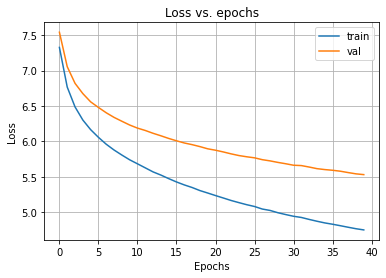

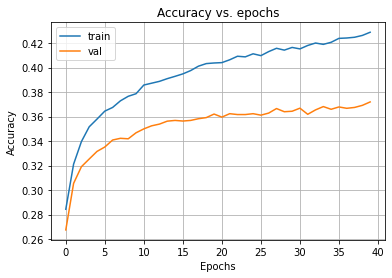

In [43]:
def plot_losses(history):
    plt.plot(history["loss_train"], label="train")
    plt.plot(history["loss_val"], label="val")
    plt.grid()
    plt.title("Loss vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
def plot_accuracies(history):
    plt.plot(history["accuracy_train"], label="train")
    plt.plot(history["accuracy_val"], label="val")
    plt.grid()
    plt.title("Accuracy vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
plot_losses(history)
plot_accuracies(history)

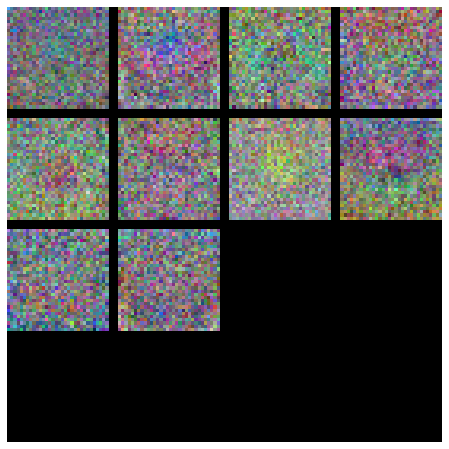

In [44]:
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    The function is taken from: https://cs231n.github.io/
    Reshape a 4D tensor of image data to a grid for easy visualization.
    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid


def viz_kernel(w, im_shape, figsize=(8,8)):
    
    w = w.reshape(im_shape + (-1,)).transpose(3, 0, 1, 2)
    plt.figure(figsize=figsize)
    plt.imshow(visualize_grid(w, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

w = model.get_trainable_weights()[-1]["w"]
im_shape=(32,32,3)
viz_kernel(w, im_shape)

In [45]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":std}

reg_rate_l2 = 0.1

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 64

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
decay_steps = 80
decay_rate = 0.9
lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)
sgd_optimizer = SGDOptimizer(lr_schedule=lr_schedule)

n_epochs = 40
batch_size = 100

for n_epoch in range(n_epochs):
    print(f"starting epoch: {n_epoch+1} ...")
    
    # Shuffle data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    n_batch = int(x_train.shape[0] / batch_size)
    
    batches = tqdm(range(n_batch))
    for b in batches:
        batches.set_description(f"batch {b+1}/{n_batch}")
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_batch = y_train[b*batch_size:(b+1)*batch_size]
    
        scores = model.forward(x_batch)
        
        layers_reg_loss = model.get_reg_loss()
        l = loss.compute_loss(scores, y_batch, layers_reg_loss)

        model.backward(y_batch) 

        trainable_weights = \
            sgd_optimizer.apply_grads(trainable_weights=model.get_trainable_weights(), 
                                      grads = model.get_gradients())

        model.set_trainable_weights(trainable_weights)
    
    scores_train = model.forward(x_train)
    
    layers_reg_loss = model.get_reg_loss()
    l_train = loss.compute_loss(scores_train, y_train, layers_reg_loss)
    
    n_train = y_train.shape[0]
    y_hat_train = np.argmax(scores_train, axis=1)
    acc_train = np.where(y_hat_train == y_train)[0].size / n_train
    
    scores_val = model.forward(x_val)
    
    layers_reg_loss = model.get_reg_loss()
    l_val = loss.compute_loss(scores_val, y_val, layers_reg_loss)
    
    n_val = y_val.shape[0]
    y_hat_val = np.argmax(scores_val, axis=1)
    acc_val = np.where(y_hat_val == y_val)[0].size / n_val
    
    print(f"epoch {n_epoch+1}/{n_epochs} \n "
          f"\t -- train loss = {l_train}, train acc = {acc_train} \n"
          f"\t -- val loss = {l_val}, val acc = {acc_val} \n\n")
    
    sgd_optimizer.apply_lr_schedule()

model summary: 
layer 0: dense: 
	 w -- init:normal ~ 1.0 x (0.0, 0.01^2), reg: l2
	 b -- init: normal ~ 1.0 x (0.0, 0.01^2)
	 activation: relu

layer 1: dense: 
	 w -- init:normal ~ 1.0 x (0.0, 0.01^2), reg: l2
	 b -- init: normal ~ 1.0 x (0.0, 0.01^2)
	 activation: softmax


starting epoch: 1 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1/40 
 	 -- train loss = 3.0027680798272023, train acc = 0.2232 
	 -- val loss = 3.0113223652337293, val acc = 0.2165 


starting epoch: 2 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 2/40 
 	 -- train loss = 2.733630869206345, train acc = 0.2729 
	 -- val loss = 2.752432569247652, val acc = 0.257 


starting epoch: 3 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 3/40 
 	 -- train loss = 2.545011338069269, train acc = 0.3062 
	 -- val loss = 2.5685965083037035, val acc = 0.289 


starting epoch: 4 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 4/40 
 	 -- train loss = 2.4012682828212757, train acc = 0.3285 
	 -- val loss = 2.4306689396999914, val acc = 0.3108 


starting epoch: 5 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 5/40 
 	 -- train loss = 2.2898235462336594, train acc = 0.3459 
	 -- val loss = 2.3230194870643706, val acc = 0.3297 


starting epoch: 6 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 6/40 
 	 -- train loss = 2.2026883785814033, train acc = 0.3599 
	 -- val loss = 2.241987527942329, val acc = 0.3431 


starting epoch: 7 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 7/40 
 	 -- train loss = 2.132861097458661, train acc = 0.369 
	 -- val loss = 2.1762530740173465, val acc = 0.3501 


starting epoch: 8 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 8/40 
 	 -- train loss = 2.0761966993755205, train acc = 0.3776 
	 -- val loss = 2.123443324723283, val acc = 0.3596 


starting epoch: 9 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 9/40 
 	 -- train loss = 2.0300408251242676, train acc = 0.3881 
	 -- val loss = 2.081326260553096, val acc = 0.3649 


starting epoch: 10 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 10/40 
 	 -- train loss = 1.9911205752263874, train acc = 0.3929 
	 -- val loss = 2.0481151326137037, val acc = 0.371 


starting epoch: 11 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 11/40 
 	 -- train loss = 1.9600464315417472, train acc = 0.4033 
	 -- val loss = 2.0204410630141645, val acc = 0.3762 


starting epoch: 12 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 12/40 
 	 -- train loss = 1.9342050129464887, train acc = 0.4044 
	 -- val loss = 1.9993706042912769, val acc = 0.3782 


starting epoch: 13 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 13/40 
 	 -- train loss = 1.9137953883842933, train acc = 0.4074 
	 -- val loss = 1.9823604651453568, val acc = 0.3793 


starting epoch: 14 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 14/40 
 	 -- train loss = 1.894418321335387, train acc = 0.417 
	 -- val loss = 1.9658851224953815, val acc = 0.3822 


starting epoch: 15 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 15/40 
 	 -- train loss = 1.8824804365952865, train acc = 0.4237 
	 -- val loss = 1.9559526830470808, val acc = 0.3864 


starting epoch: 16 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 16/40 
 	 -- train loss = 1.8690917890441465, train acc = 0.427 
	 -- val loss = 1.9470191048362153, val acc = 0.3887 


starting epoch: 17 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 17/40 
 	 -- train loss = 1.8575064732206394, train acc = 0.4273 
	 -- val loss = 1.9378058602241852, val acc = 0.392 


starting epoch: 18 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 18/40 
 	 -- train loss = 1.849665512119882, train acc = 0.4342 
	 -- val loss = 1.9305288877202837, val acc = 0.3973 


starting epoch: 19 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 19/40 
 	 -- train loss = 1.8424568652765703, train acc = 0.4335 
	 -- val loss = 1.9260939916395452, val acc = 0.3954 


starting epoch: 20 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 20/40 
 	 -- train loss = 1.8345569249947105, train acc = 0.4397 
	 -- val loss = 1.9205956234769719, val acc = 0.3999 


starting epoch: 21 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 21/40 
 	 -- train loss = 1.8305919798446046, train acc = 0.441 
	 -- val loss = 1.9183190438706008, val acc = 0.4017 


starting epoch: 22 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 22/40 
 	 -- train loss = 1.8251866495603146, train acc = 0.4445 
	 -- val loss = 1.9163977166479773, val acc = 0.4 


starting epoch: 23 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 23/40 
 	 -- train loss = 1.8210011455237063, train acc = 0.4498 
	 -- val loss = 1.9128678972737685, val acc = 0.4015 


starting epoch: 24 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 24/40 
 	 -- train loss = 1.8173927319684724, train acc = 0.452 
	 -- val loss = 1.9115045049808317, val acc = 0.4038 


starting epoch: 25 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 25/40 
 	 -- train loss = 1.8144618085498554, train acc = 0.4544 
	 -- val loss = 1.9099701174493935, val acc = 0.4054 


starting epoch: 26 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 26/40 
 	 -- train loss = 1.8114590966024224, train acc = 0.4528 
	 -- val loss = 1.909125727232451, val acc = 0.4064 


starting epoch: 27 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 27/40 
 	 -- train loss = 1.8090330862537938, train acc = 0.4551 
	 -- val loss = 1.9087306609977226, val acc = 0.4065 


starting epoch: 28 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 28/40 
 	 -- train loss = 1.8069026788075488, train acc = 0.4587 
	 -- val loss = 1.9072755881455152, val acc = 0.4083 


starting epoch: 29 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 29/40 
 	 -- train loss = 1.8063637585168086, train acc = 0.4602 
	 -- val loss = 1.9081883784661, val acc = 0.4104 


starting epoch: 30 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 30/40 
 	 -- train loss = 1.8038877757451763, train acc = 0.461 
	 -- val loss = 1.9069583963772756, val acc = 0.408 


starting epoch: 31 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 31/40 
 	 -- train loss = 1.8029290972496854, train acc = 0.4639 
	 -- val loss = 1.9067620557372347, val acc = 0.414 


starting epoch: 32 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 32/40 
 	 -- train loss = 1.8030711826258434, train acc = 0.4625 
	 -- val loss = 1.9088066578438936, val acc = 0.4104 


starting epoch: 33 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 33/40 
 	 -- train loss = 1.8003026489109684, train acc = 0.4643 
	 -- val loss = 1.9079760242271862, val acc = 0.4114 


starting epoch: 34 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 34/40 
 	 -- train loss = 1.7993122366853804, train acc = 0.467 
	 -- val loss = 1.9083528706042034, val acc = 0.4142 


starting epoch: 35 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 35/40 
 	 -- train loss = 1.7980961903632278, train acc = 0.4675 
	 -- val loss = 1.9074777803402243, val acc = 0.414 


starting epoch: 36 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 36/40 
 	 -- train loss = 1.7970575449419273, train acc = 0.4697 
	 -- val loss = 1.9058436197115758, val acc = 0.4164 


starting epoch: 37 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 37/40 
 	 -- train loss = 1.7978589619952163, train acc = 0.4656 
	 -- val loss = 1.9090784918030275, val acc = 0.4124 


starting epoch: 38 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 38/40 
 	 -- train loss = 1.7977525643083, train acc = 0.4735 
	 -- val loss = 1.9087640834906283, val acc = 0.4128 


starting epoch: 39 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 39/40 
 	 -- train loss = 1.7965356628709794, train acc = 0.4676 
	 -- val loss = 1.9086333109295293, val acc = 0.4156 


starting epoch: 40 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 40/40 
 	 -- train loss = 1.7963942084819264, train acc = 0.4727 
	 -- val loss = 1.907736632313935, val acc = 0.4177 




model summary: 
layer 0: dense: 
	 w -- init:normal ~ 1.0 x (0.0, 0.01^2), reg: l2
	 b -- init: normal ~ 1.0 x (0.0, 0.01^2)
	 activation: relu

layer 1: dense: 
	 w -- init:normal ~ 1.0 x (0.0, 0.01^2), reg: l2
	 b -- init: normal ~ 1.0 x (0.0, 0.01^2)
	 activation: softmax


starting epoch: 1 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1/40 
 	 -- train loss = 2.993480781535883, train accuracy = 0.2268 
	 -- val loss = 3.002189715249619, val accuracy = 0.2144 


starting epoch: 2 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 2/40 
 	 -- train loss = 2.7303309565824576, train accuracy = 0.2756 
	 -- val loss = 2.7490879063550397, val accuracy = 0.2582 


starting epoch: 3 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 3/40 
 	 -- train loss = 2.5446189883090415, train accuracy = 0.31 
	 -- val loss = 2.5681587064068765, val accuracy = 0.2926 


starting epoch: 4 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 4/40 
 	 -- train loss = 2.4028813221662, train accuracy = 0.3312 
	 -- val loss = 2.4316163016232393, val accuracy = 0.3115 


starting epoch: 5 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 5/40 
 	 -- train loss = 2.2919216739494583, train accuracy = 0.3476 
	 -- val loss = 2.3257123336432137, val accuracy = 0.3328 


starting epoch: 6 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 6/40 
 	 -- train loss = 2.205114787130855, train accuracy = 0.3582 
	 -- val loss = 2.2438497932862056, val accuracy = 0.3396 


starting epoch: 7 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 7/40 
 	 -- train loss = 2.1336060072055263, train accuracy = 0.3696 
	 -- val loss = 2.177083835722126, val accuracy = 0.3529 


starting epoch: 8 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 8/40 
 	 -- train loss = 2.07728397049587, train accuracy = 0.3816 
	 -- val loss = 2.1257462153781024, val accuracy = 0.3603 


starting epoch: 9 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 9/40 
 	 -- train loss = 2.0297963116267166, train accuracy = 0.3901 
	 -- val loss = 2.082493318933123, val accuracy = 0.3649 


starting epoch: 10 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 10/40 
 	 -- train loss = 1.991608299824464, train accuracy = 0.3995 
	 -- val loss = 2.0477671706073526, val accuracy = 0.371 


starting epoch: 11 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 11/40 
 	 -- train loss = 1.9621971963553935, train accuracy = 0.4017 
	 -- val loss = 2.0221466963898944, val accuracy = 0.3744 


starting epoch: 12 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 12/40 
 	 -- train loss = 1.9337989556144235, train accuracy = 0.4082 
	 -- val loss = 1.9963112671200594, val accuracy = 0.3808 


starting epoch: 13 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 13/40 
 	 -- train loss = 1.9121648044898134, train accuracy = 0.4161 
	 -- val loss = 1.978304851629801, val accuracy = 0.3858 


starting epoch: 14 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 14/40 
 	 -- train loss = 1.8933206713813886, train accuracy = 0.4202 
	 -- val loss = 1.963213516049985, val accuracy = 0.3882 


starting epoch: 15 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 15/40 
 	 -- train loss = 1.8788898584484535, train accuracy = 0.4242 
	 -- val loss = 1.9507752184486042, val accuracy = 0.3905 


starting epoch: 16 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 16/40 
 	 -- train loss = 1.8666291640674426, train accuracy = 0.4259 
	 -- val loss = 1.943586821267323, val accuracy = 0.39 


starting epoch: 17 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 17/40 
 	 -- train loss = 1.8551566132344237, train accuracy = 0.4344 
	 -- val loss = 1.933377888573369, val accuracy = 0.3987 


starting epoch: 18 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 18/40 
 	 -- train loss = 1.8468646086783833, train accuracy = 0.4337 
	 -- val loss = 1.9300579042955437, val accuracy = 0.3937 


starting epoch: 19 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 19/40 
 	 -- train loss = 1.8386890992916776, train accuracy = 0.4377 
	 -- val loss = 1.922690163172842, val accuracy = 0.3986 


starting epoch: 20 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 20/40 
 	 -- train loss = 1.8340248327035737, train accuracy = 0.4421 
	 -- val loss = 1.9186699553312383, val accuracy = 0.4062 


starting epoch: 21 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 21/40 
 	 -- train loss = 1.8272220082277186, train accuracy = 0.4442 
	 -- val loss = 1.9146620780640318, val accuracy = 0.4066 


starting epoch: 22 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 22/40 
 	 -- train loss = 1.8225302849238731, train accuracy = 0.4472 
	 -- val loss = 1.9122148355541297, val accuracy = 0.4057 


starting epoch: 23 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 23/40 
 	 -- train loss = 1.8183318745440171, train accuracy = 0.4471 
	 -- val loss = 1.9114823438531459, val accuracy = 0.4065 


starting epoch: 24 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 24/40 
 	 -- train loss = 1.8160231435588672, train accuracy = 0.451 
	 -- val loss = 1.908931931897929, val accuracy = 0.4097 


starting epoch: 25 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 25/40 
 	 -- train loss = 1.814613281973107, train accuracy = 0.4505 
	 -- val loss = 1.909942534616896, val accuracy = 0.4103 


starting epoch: 26 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 26/40 
 	 -- train loss = 1.8107777466598394, train accuracy = 0.4534 
	 -- val loss = 1.9077328981167114, val accuracy = 0.411 


starting epoch: 27 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 27/40 
 	 -- train loss = 1.8081253105220034, train accuracy = 0.4584 
	 -- val loss = 1.906151705959298, val accuracy = 0.4154 


starting epoch: 28 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 28/40 
 	 -- train loss = 1.8063018034647476, train accuracy = 0.4555 
	 -- val loss = 1.905828669421641, val accuracy = 0.4134 


starting epoch: 29 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 29/40 
 	 -- train loss = 1.8040137970954992, train accuracy = 0.4643 
	 -- val loss = 1.9041525529677936, val accuracy = 0.4186 


starting epoch: 30 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 30/40 
 	 -- train loss = 1.8037212843265558, train accuracy = 0.4651 
	 -- val loss = 1.9047394137121216, val accuracy = 0.4191 


starting epoch: 31 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 31/40 
 	 -- train loss = 1.802323977544469, train accuracy = 0.4645 
	 -- val loss = 1.9048174083512515, val accuracy = 0.4198 


starting epoch: 32 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 32/40 
 	 -- train loss = 1.7999863828338531, train accuracy = 0.4644 
	 -- val loss = 1.9051854038456857, val accuracy = 0.4172 


starting epoch: 33 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 33/40 
 	 -- train loss = 1.7995901850883642, train accuracy = 0.4662 
	 -- val loss = 1.9066613093437565, val accuracy = 0.4162 


starting epoch: 34 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 34/40 
 	 -- train loss = 1.799267500173769, train accuracy = 0.4643 
	 -- val loss = 1.9078327838143387, val accuracy = 0.4173 


starting epoch: 35 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 35/40 
 	 -- train loss = 1.7976116483499904, train accuracy = 0.4682 
	 -- val loss = 1.9051273926984367, val accuracy = 0.4181 


starting epoch: 36 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 36/40 
 	 -- train loss = 1.7957228981271462, train accuracy = 0.4702 
	 -- val loss = 1.9044616801063383, val accuracy = 0.4198 


starting epoch: 37 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 37/40 
 	 -- train loss = 1.795743525349783, train accuracy = 0.4703 
	 -- val loss = 1.9059392306959413, val accuracy = 0.422 


starting epoch: 38 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 38/40 
 	 -- train loss = 1.7963839716970047, train accuracy = 0.4709 
	 -- val loss = 1.9094007733258604, val accuracy = 0.4137 


starting epoch: 39 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 39/40 
 	 -- train loss = 1.7960619189955915, train accuracy = 0.4731 
	 -- val loss = 1.9057990304842611, val accuracy = 0.4195 


starting epoch: 40 ...


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 40/40 
 	 -- train loss = 1.794300538172, train accuracy = 0.4712 
	 -- val loss = 1.9068106272060372, val accuracy = 0.4199 




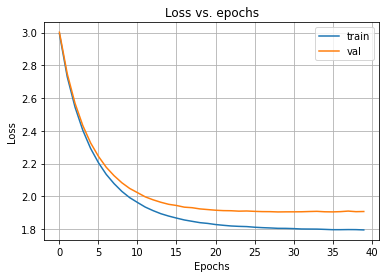

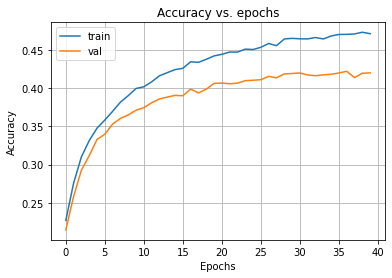

In [48]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":std}

reg_rate_l2 = 0.1

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 64

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
decay_steps = 80
decay_rate = 0.9
lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

n_epochs = 40
batch_size = 100

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_accuracies(history)

In [49]:
def loss_func(model, loss, x, y, **param_dict):
    
    layer_idx = deepcopy(param_dict["layer_idx"])
    # w or b
    param_str = deepcopy(param_dict["param_str"])
    # np matrix
    param_val = deepcopy(param_dict["param_val"])
    
    trainable_weights = model.get_trainable_weights()
    trainable_weights[layer_idx][param_str] = deepcopy(param_val)
    model.set_trainable_weights(trainable_weights)
    
    scores = model.forward(x)
    layers_reg_loss = model.get_reg_loss()
    l = loss.compute_loss(scores, y, layers_reg_loss)
    
    return l

def get_num_gradient(model, loss, x, y, verbose, **param_dict):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    #fx = f(x) # evaluate function value at original point
    l = loss_func(model, loss, x, y, **param_dict)
    
    param_val = deepcopy(param_dict["param_val"])
    grad = np.zeros(param_val.shape)
    h = 0.00001

    # iterate over all indexes in x
    
    if verbose:
        pbar = tqdm(total=param_val.size)
    
    it = np.nditer(param_val, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        #print(ix)
        
        old_value = param_val[ix]
        param_val[ix] = old_value + h # increment by h
        
        param_dict["param_val"] = deepcopy(param_val)
        
        #fxph = f(x) # evalute f(x + h)
        lxph = loss_func(model, loss, x, y, **param_dict)
        
        param_val[ix] = old_value - h # decrease by h
        
        param_dict["param_val"] = deepcopy(param_val)
        
        #fxmh = f(x) # evalute f(x - h)
        
        lxmh = loss_func(model, loss, x, y, **param_dict)
        
        param_val[ix] = old_value # restore to previous value (very important!)
        
        # compute the partial derivative
        # the slope
        grad[ix] = (lxph - lxmh) / (2*h)
        it.iternext() # step to next dimension
        
        if verbose:
            pbar.update(1)
    
    if verbose:
        pbar.close()

    return grad

In [50]:
def grad_check_without_reg(model, loss, x, y, verbose, seed=None):
    # does not include w regularization in numerical grad computation
    assert x.shape[0] == y.shape[0], "x and y have different number of data points"
    print(f"starting grad check with {x.shape[0]} data points \n")
    print(model)
    print("\n")
    
    layer_n = len(model.layers)
    
    for layer_idx, trainable_weights_in_layer in enumerate(model.get_trainable_weights()):
        
        for param_str, param_val in trainable_weights_in_layer.items():

            model_new = deepcopy(model)

            trainable_weights = model_new.get_trainable_weights()

            np.random.seed(seed)
            new_param_val = np.random.normal(loc=0, scale=0.01, size=param_val.shape)

            param_dict = {
                "layer_idx": layer_idx, 
                "param_str": param_str,
                "param_val": new_param_val
            }

            trainable_weights[layer_idx][param_str] = deepcopy(new_param_val)
            model_new.set_trainable_weights(trainable_weights)
            
            print(f"--layer: {layer_idx+1}/{layer_n}, "
                  f"{param_str}.shape={param_val.shape} ({param_val.size} params)")
            
            grad_numerical = get_num_gradient(deepcopy(model_new), loss, x, y, verbose, **param_dict)

            scores = model_new.forward(x)
            layers_reg_loss = 0

            l = loss.compute_loss(scores, y, model_new.get_reg_loss())

            model_new.backward(loss.grad())

            grads_analytic = model_new.get_gradients()

            grad_analytic = deepcopy(grads_analytic[layer_idx]["d" + param_str])
            
            rel_error = np.abs(grad_analytic - grad_numerical)\
                /(np.maximum(np.abs(grad_analytic), np.abs(grad_numerical)))

            decimal = 6
            np.testing.assert_array_almost_equal(grad_numerical, grad_analytic, decimal=decimal)
            print(f"analytic and numerical grads are equal up to {decimal} decimals")
            print(f"max rel error={np.max(rel_error):.6e}")
            print(f"passed\n")
    
    print(f"completed grad check\n")

In [53]:
# Grad check
params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 16

dense_1 = \
    Dense(in_dim=in_dim, out_dim=out_dim, 
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=None, 
          activation=SoftmaxActivation()#LinearActivation()
         )

"""dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim, 
          kernel_initializer=NormalInitializer(seed=None, **params), 
          bias_initializer=NormalInitializer(seed=None, **params), 
          kernel_regularizer=None,
          activation=LinearActivation()#SoftmaxActivation()
         )"""

layers = [
    dense_1
]

model = Model(layers)

loss = CategoricalCrossEntropyLoss()
#loss = CategoricalHingeLoss()

verbose = True
grad_check_without_reg(model, loss, x_train[:2], y_train[:2], verbose, seed=102)

starting grad check with 2 data points 

model summary: 
layer 0: dense: 
	 w -- init:normal ~ 1.0 x (0.0, 0.01^2), reg: None
	 b -- init: normal ~ 1.0 x (0.0, 0.01^2)
	 activation: softmax




--layer: 1/1, w.shape=(3072, 10) (30720 params)


  0%|          | 0/30720 [00:00<?, ?it/s]

analytic and numerical grads are equal up to 6 decimals
max rel error=6.957111e-06
passed

--layer: 1/1, b.shape=(1, 10) (10 params)


  0%|          | 0/10 [00:00<?, ?it/s]

analytic and numerical grads are equal up to 6 decimals
max rel error=2.513676e-10
passed

completed grad check



In [54]:
# unittest grad check without reg
# Grad check

def test_grad_check_without_reg_softmax_cat_cross_entropy_one_layer(seed=None):

    params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}
    
    n_data = 2
    in_dim = 500
    out_dim = 5
    
    x_size = (n_data, in_dim)
    np.random.seed(seed)
    x = np.random.normal(loc=0, scale=1, size=x_size)
    
    y_size = (n_data,)
    np.random.seed(seed)
    y = np.random.randint(low=0, high=out_dim, size=y_size)
    
    
    dense_1 = \
        Dense(in_dim=in_dim, out_dim=out_dim, 
              kernel_initializer=NormalInitializer(seed=None, **params), 
              bias_initializer=NormalInitializer(seed=None, **params), 
              kernel_regularizer=None, 
              activation=SoftmaxActivation()
             )

    layers = [
        dense_1
    ]

    model = Model(layers)

    loss = CategoricalCrossEntropyLoss()
    
    verbose = True
    grad_check_without_reg(model, loss, x, y, verbose, seed=seed+1)
    
    print("test_grad_check_without_reg_softmax_cat_cross_entropy_one_layer passed")

test_grad_check_without_reg_softmax_cat_cross_entropy_one_layer(seed=100)

starting grad check with 2 data points 

model summary: 
layer 0: dense: 
	 w -- init:normal ~ 1.0 x (0.0, 0.01^2), reg: None
	 b -- init: normal ~ 1.0 x (0.0, 0.01^2)
	 activation: softmax




--layer: 1/1, w.shape=(500, 5) (2500 params)


  0%|          | 0/2500 [00:00<?, ?it/s]

analytic and numerical grads are equal up to 6 decimals
max rel error=3.379875e-08
passed

--layer: 1/1, b.shape=(1, 5) (5 params)


  0%|          | 0/5 [00:00<?, ?it/s]

analytic and numerical grads are equal up to 6 decimals
max rel error=3.812919e-11
passed

completed grad check

test_grad_check_without_reg_softmax_cat_cross_entropy_one_layer passed


In [55]:
# unittest grad check without reg
# Grad check

def test_grad_check_without_reg_linear_hinge_one_layer(seed=None):

    params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}
    
    n_data = 2
    in_dim = 500
    out_dim = 5
    
    x_size = (n_data, in_dim)
    np.random.seed(seed)
    x = np.random.normal(loc=0, scale=1, size=x_size)
    
    y_size = (n_data,)
    np.random.seed(seed)
    y = np.random.randint(low=0, high=out_dim, size=y_size)
    
    
    dense_2 = \
        Dense(in_dim=in_dim, out_dim=out_dim, 
              kernel_initializer=NormalInitializer(seed=None, **params), 
              bias_initializer=NormalInitializer(seed=None, **params), 
              kernel_regularizer=None, 
              activation=LinearActivation()
             )

    layers = [
        dense_2
    ]

    model = Model(layers)

    loss = CategoricalHingeLoss()
    
    verbose = True
    grad_check_without_reg(model, loss, x, y, verbose, seed=seed+1)
    
    print("test_grad_check_without_reg_linear_hinge_one_layer passed")

test_grad_check_without_reg_linear_hinge_one_layer(seed=100)

starting grad check with 2 data points 

model summary: 
layer 0: dense: 
	 w -- init:normal ~ 1.0 x (0.0, 0.01^2), reg: None
	 b -- init: normal ~ 1.0 x (0.0, 0.01^2)
	 activation: linear




--layer: 1/1, w.shape=(500, 5) (2500 params)


  0%|          | 0/2500 [00:00<?, ?it/s]

analytic and numerical grads are equal up to 6 decimals
max rel error=3.823995e-09
passed

--layer: 1/1, b.shape=(1, 5) (5 params)


  0%|          | 0/5 [00:00<?, ?it/s]

analytic and numerical grads are equal up to 6 decimals
max rel error=2.875566e-11
passed

completed grad check

test_grad_check_without_reg_linear_hinge_one_layer passed


In [56]:
test_linear_activation()
test_relu_activation()
test_normal_initializer(seed=100)
test_dense_param_init(seed=100)
test_dense_forward(seed=100)
test_dense_backward_relu_linear(seed=100)
test_dense_backward_softmax(seed=100)
test_categoical_cross_entropy_loss()

test_linear_activation passed
test_relu_activation passed
test_normal_initializer passed
test_dense_param_init passed
activation: <class '__main__.LinearActivation'>
activation: <class '__main__.ReLUActivation'>
activation: <class '__main__.SoftmaxActivation'>
test_dense_forward_with_linear_activation passing
activation: <class '__main__.LinearActivation'>
activation: <class '__main__.ReLUActivation'>
test_dense_backward_relu_linear passing
test_dense_backward_softmax passing
test_categoical_cross_entropy_loss passed
